
# **0. 준비**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [3]:
# 시각화에 사용할 팔레트
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')


# **1. 데이터 구조 파악**

#### **(1) 데이터 불러오기**

[Feature variable] - 10개
* tm : 시간 (날짜 및 시각, 00시~23시)
* branch_id : 지사명 (비식별화 처리)
* ta : 기온 (정시 기온,°C)
* wd : 풍향 (정시 10분 평균 풍향, degree)
* ws : 풍속 (정시 10분 평균 풍속, m/s)
* rn_day : 일 강수량 (해당 시간까지의 일강수량, mm)
* rn_hr1 : 시간 강수량 (1시간 강수량, mm)
* hm : 상대 습도 (정시 상대 습도, %)
* si : 일사량 (ASOS 일사량, MJ/m^2)
* ta_chi : 체감온도 (500m 객관분석 자료,°C)

[Target Variable]
* heat_demand : 열수요 (시간당 지사별 열 공급량, Gcal/h)

In [4]:
# train data 불러오기
df_train = pd.read_csv("/content/drive/MyDrive/weather_bigcontest/data/train_heat.csv")
df_train = df_train.iloc[:,1:]
df_train

,train_heat.tm,train_heat.branch_id,train_heat.ta,train_heat.wd,train_heat.ws,train_heat.rn_day,train_heat.rn_hr1,train_heat.hm,train_heat.si,train_heat.ta_chi,train_heat.heat_demand
0,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
1,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
2,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
3,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
4,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283
...,...,...,...,...,...,...,...,...,...,...,...
499296,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,-99.0,2.8,34
499297,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,-99.0,2.7,35
499298,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,-99.0,1.4,35
499299,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,-99.0,1.3,40


#### **(2) 데이터 확인하기**

In [5]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [6]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [7]:
df_train.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283


In [8]:
df_train.shape # 12개의 열, 10999개의 행

(499301, 11)

In [9]:
df_train.describe()

,tm,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,499301,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000
mean,2022-07-02 12:00:00,10.621007,194.322872,-2.344705,-1.843207,-3.649492,53.024052,-45.600886,13.869692,95.861923
min,2021-01-01 01:00:00,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
25%,2021-10-01 18:00:00,4.400000,105.000000,0.500000,0.000000,0.000000,44.900000,-99.000000,4.400000,25.000000
50%,2022-07-02 12:00:00,14.200000,212.100000,1.100000,0.000000,0.000000,64.700000,0.000000,15.000000,55.000000
75%,2023-04-02 06:00:00,22.500000,294.300000,2.000000,0.000000,0.000000,82.500000,0.960000,24.300000,116.000000
max,2023-12-31 23:00:00,37.800000,360.000000,11.900000,326.500000,92.500000,100.000000,3.920000,37.100000,966.000000
std,NaN,20.878917,118.348853,19.161911,21.340679,19.082926,49.080340,49.938291,11.888126,115.269280


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           499301 non-null  float64       
 3   wd           499301 non-null  float64       
 4   ws           499301 non-null  float64       
 5   rn_day       499301 non-null  float64       
 6   rn_hr1       499301 non-null  float64       
 7   hm           499301 non-null  float64       
 8   si           499301 non-null  float64       
 9   ta_chi       499301 non-null  float64       
 10  heat_demand  499301 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 41.9+ MB


=> 실제로는 결측치가 -99로 되어있어 존재함.

In [11]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


In [12]:
# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: []


In [13]:
# -9.9 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ta_chi']


>  wd는 -9.9도 null임



In [14]:
# -9.9를 np.nan으로 바꾸기
df_train['wd'] = df_train['wd'].replace(-9.9, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-9.9' 포함 열:", cols_with_neg99)

'-9.9' 포함 열: ['ta', 'ta_chi']


* 다시 데이터 확인

In [15]:
df_train.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,281.0
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,262.0
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,266.0
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,285.0
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,283.0


In [16]:
df_train.shape

(499301, 11)

In [17]:
df_train.describe()

,tm,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,499301,486304.000000,478897.000000,480486.000000,480675.000000,480147.000000,459584.000000,266379.000000,499281.000000,499278.000000
mean,2022-07-02 12:00:00,13.550747,206.524619,1.440149,1.921587,0.154225,66.161889,1.091339,13.874214,95.870900
min,2021-01-01 01:00:00,-19.700000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,-24.700000,0.000000
25%,2021-10-01 18:00:00,5.200000,119.500000,0.500000,0.000000,0.000000,50.300000,0.210000,4.400000,25.000000
50%,2022-07-02 12:00:00,14.700000,221.600000,1.200000,0.000000,0.000000,67.600000,0.850000,15.000000,55.000000
75%,2023-04-02 06:00:00,22.700000,297.400000,2.100000,0.000000,0.000000,84.000000,1.820000,24.300000,116.000000
max,2023-12-31 23:00:00,37.800000,360.000000,11.900000,326.500000,92.500000,100.000000,3.920000,37.100000,966.000000
std,NaN,10.855174,104.573652,1.185264,9.649994,1.236777,21.146626,0.972380,11.866881,115.264347


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           486304 non-null  float64       
 3   wd           478897 non-null  float64       
 4   ws           480486 non-null  float64       
 5   rn_day       480675 non-null  float64       
 6   rn_hr1       480147 non-null  float64       
 7   hm           459584 non-null  float64       
 8   si           266379 non-null  float64       
 9   ta_chi       499281 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [19]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing Ratio (%)
si                  232922          46.649616
hm                   39717           7.954520
wd                   20404           4.086513
rn_hr1               19154           3.836163
ws                   18815           3.768268
rn_day               18626           3.730415
ta                   12997           2.603039
heat_demand             23           0.004606
ta_chi                  20           0.004006


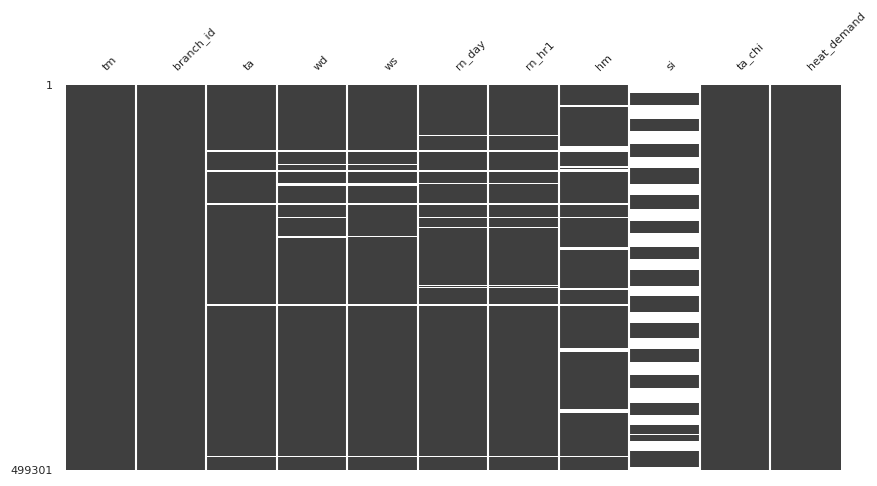

In [20]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

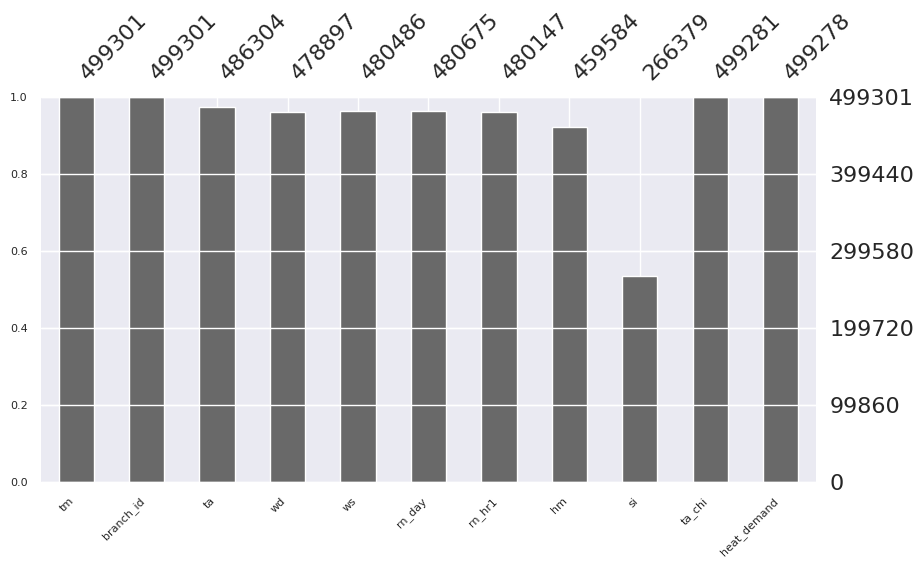

In [21]:
# 막대그래프 형태로 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df_train, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

* Target에 결측치가 있는 경우 데이터 삭제

In [22]:
# 타겟 변수 heat_demand에 결측이 있는 행 제거
df_train = df_train.dropna(subset=['heat_demand']).reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           266370 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


* 시간 관련 변수 생성

In [23]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [35]:
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day'] = df_train['tm'].dt.day # 월
df_train['hour'] = df_train['tm'].dt.hour
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [36]:
df_train.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,year,quarter,month,day_of_week,season,is_weekend,weekofyear,hour_group,day,hour
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,...,2021,1,1,4,Winter,Weekday,53,0,1,1
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,...,2021,1,1,4,Winter,Weekday,53,0,1,2
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,...,2021,1,1,4,Winter,Weekday,53,1,1,3
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,...,2021,1,1,4,Winter,Weekday,53,1,1,4
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,...,2021,1,1,4,Winter,Weekday,53,1,1,5


* si 결측 처리

In [37]:
# 공통 규칙 정의

# A,B,C,F
common_night_rules_1 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 13), 21, 6),
    ((4, 13), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 12), 20, 6),
    ((10, 12), (11, 3), 19, 6),
    ((11, 3), (12, 31), 19, 7)
]

# D,E,G,H,I,J,K,S
common_night_rules_2 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 4), 19, 6),
    ((11, 4), (12, 31), 19, 7)
]

# L,M,N
common_night_rules_3 = [
    ((1, 1), (2, 10), 19, 7),
    ((2, 10), (2, 25), 20, 7),
    ((2, 25), (4, 9), 20, 6),
    ((4, 9), (4, 19), 20, 5),
    ((4, 19), (8, 26), 21, 5),
    ((8, 26), (9, 4), 20, 5),
    ((9, 4), (10, 7), 20, 6),
    ((10, 7), (11, 13), 19, 6),
    ((11, 13), (12, 31), 19, 7)
]

# O
common_night_rules_4 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 2), 20, 7),
    ((3, 2), (4, 11), 20, 6),
    ((4, 11), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 1), 21, 6),
    ((9, 1), (10, 11), 20, 6),
    ((10, 11), (11, 7), 19, 6),
    ((11, 7), (12, 31), 19, 7)
]

# P
common_night_rules_5 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 3), 20, 7),
    ((3, 3), (4, 10), 20, 6),
    ((4, 10), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 2), 21, 6),
    ((9, 2), (10, 12), 20, 6),
    ((10, 12), (11, 6), 19, 6),
    ((11, 6), (12, 31), 19, 7)
]

# Q
common_night_rules_6 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 5), 20, 7),
    ((3, 5), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 2), 19, 6),
    ((11, 2), (12, 31), 19, 7)
]

# R
common_night_rules_7 = [
    ((1, 1), (2, 1), 19, 7),
    ((2, 1), (3, 2), 20, 7),
    ((3, 2), (4, 9), 20, 6),
    ((4, 9), (4, 15), 21, 6),
    ((4, 15), (8, 26), 21, 5),
    ((8, 26), (9, 2), 21, 6),
    ((9, 2), (10, 14), 20, 6),
    ((10, 14), (11, 8), 19, 6),
    ((11, 8), (12, 31), 19, 7)
]


# 브랜치별 야간 시간 규칙 딕셔너리
branch_night_rules = {
    'A': common_night_rules_1,
    'B': common_night_rules_1,
    'C': common_night_rules_1,
    'D': common_night_rules_2,
    'E': common_night_rules_2,
    'F': common_night_rules_1,
    'G': common_night_rules_2,
    'H': common_night_rules_2,
    'I': common_night_rules_2,
    'J': common_night_rules_2,
    'K': common_night_rules_2,
    'L': common_night_rules_3,
    'M': common_night_rules_3,
    'N': common_night_rules_3,
    'O': common_night_rules_4,
    'P': common_night_rules_5,
    'Q': common_night_rules_6,
    'R': common_night_rules_7,
    'S': common_night_rules_2
}


In [39]:
# 모든 브랜치에 대해 야간 시간 적용
for branch, rules in branch_night_rules.items():
    is_branch = df_train['branch_id'] == branch

    for (start_m, start_d), (end_m, end_d), night_start, night_end in rules:
        in_period = (
            ((df_train['month'] > start_m) | ((df_train['month'] == start_m) & (df_train['day'] >= start_d))) &
            ((df_train['month'] < end_m) | ((df_train['month'] == end_m) & (df_train['day'] <= end_d)))
        )

        if night_start > night_end:  # 자정을 넘기는 경우
            in_night = (df_train['hour'] >= night_start) | (df_train['hour'] <= night_end)
        else:
            in_night = (df_train['hour'] >= night_start) & (df_train['hour'] < night_end)

        # 조건에 맞는 행에 대해 si 값 0으로 설정
        mask = is_branch & in_period & in_night
        df_train.loc[mask, 'si'] = 0

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           488931 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
 11  year         499278 non-null  int32         
 12  quarter      499278 non-null  int32         
 13  month        499278 non-null  int32         
 14  day_of_week  499278 non-null  int32         
 15  season       499278 non-null  obje

In [41]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
hm              39711           7.953685
wd              20402           4.086301
rn_hr1          19152           3.835939
ws              18813           3.768041
rn_day          18624           3.730186
ta              12995           2.602758
si              10347           2.072393
ta_chi             20           0.004006


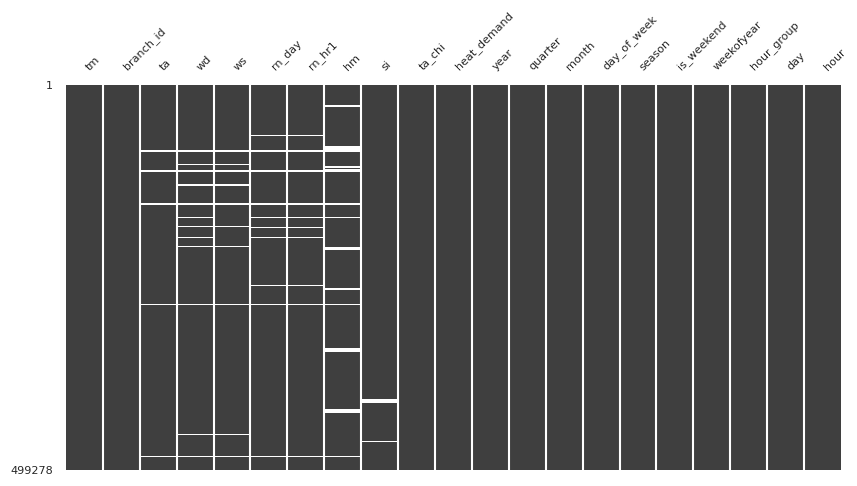

In [42]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

# **2. EDA**

Cluster 0: ['E', 'F', 'I', 'J', 'K', 'N', 'O', 'Q']

Cluster 1: ['B', 'C', 'G']

Cluster 2: ['A', 'D', 'H', 'P']

Cluster 3: ['L', 'M', 'R', 'S']

## **2-0. 클러스터별 비교**

아직 하진 않았지만, 나중에 보고서 만들 때 클러스터별 차이를 명확히 보여줄 수 있는 그래프 몇 개가 필요하다면 하면 좋을 거 같아요! (우선 그룹별 EDA부터 ..)

## **2-1. cluster 0**

### **0) 데이터 확인하기**

In [ ]:
cluster0_branch_ids = ['E', 'F', 'I', 'J', 'K', 'N', 'O', 'Q']
df_train_cluster0 = df_train[df_train['branch_id'].isin(cluster0_branch_ids)]

In [ ]:
df_train_cluster0.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day_of_week,season,is_weekend,weekofyear,hour_group
105112,2021-01-01 01:00:00,E,-7.0,282.3,0.9,0.0,0.0,NaN,NaN,-8.1,115.0,2021,1,1,4,Winter,Weekday,53,0
105113,2021-01-01 02:00:00,E,-8.4,152.9,0.7,0.0,0.0,NaN,NaN,-9.2,109.0,2021,1,1,4,Winter,Weekday,53,0
105114,2021-01-01 03:00:00,E,-8.9,167.2,0.4,0.0,0.0,NaN,NaN,-9.8,109.0,2021,1,1,4,Winter,Weekday,53,1
105115,2021-01-01 04:00:00,E,-8.5,271.5,0.4,0.0,0.0,NaN,NaN,-9.8,109.0,2021,1,1,4,Winter,Weekday,53,1
105116,2021-01-01 05:00:00,E,-9.7,189.6,0.4,0.0,0.0,NaN,NaN,-10.4,111.0,2021,1,1,4,Winter,Weekday,53,1


In [ ]:
df_train_cluster0.shape # 12개의 열, 10999개의 행

(210218, 19)

In [ ]:
df_train_cluster0.describe()

,tm,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day_of_week,weekofyear,hour_group
count,210218,202445.000000,200065.000000,200115.000000,200352.000000,200161.000000,182522.000000,118314.000000,210199.000000,210218.000000,210218.000000,210218.000000,210218.000000,210218.000000,210218.0,210218.000000
mean,2022-07-02 12:09:15.760210944,13.165004,216.068185,1.347934,1.875330,0.151147,64.682089,1.071684,13.634465,69.160529,2022.000057,2.509642,6.526216,3.005428,26.571545,3.500285
min,2021-01-01 01:00:00,-19.700000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,-24.700000,0.000000,2021.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,2021-10-01 19:00:00,4.600000,130.800000,0.500000,0.000000,0.000000,48.900000,0.190000,4.100000,29.000000,2021.000000,2.000000,4.000000,1.000000,14.0,2.000000
50%,2022-07-02 12:30:00,14.300000,242.700000,1.100000,0.000000,0.000000,65.800000,0.830000,14.800000,52.000000,2022.000000,3.000000,7.000000,3.000000,27.0,4.000000
75%,2023-04-02 06:00:00,22.400000,300.200000,2.000000,0.000000,0.000000,82.200000,1.800000,24.200000,96.000000,2023.000000,4.000000,10.000000,5.000000,40.0,6.000000
max,2023-12-31 23:00:00,37.200000,360.000000,9.600000,276.000000,91.500000,100.000000,3.920000,36.700000,365.000000,2023.000000,4.000000,12.000000,6.000000,53.0,7.000000
std,NaN,10.998412,104.414911,1.103621,9.725293,1.207923,20.960806,0.969970,12.001680,52.683465,0.816489,1.116769,3.447814,2.000484,15.051291,2.291221


In [ ]:
df_train_cluster0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210218 entries, 105112 to 446723
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           210218 non-null  datetime64[ns]
 1   branch_id    210218 non-null  object        
 2   ta           202445 non-null  float64       
 3   wd           200065 non-null  float64       
 4   ws           200115 non-null  float64       
 5   rn_day       200352 non-null  float64       
 6   rn_hr1       200161 non-null  float64       
 7   hm           182522 non-null  float64       
 8   si           118314 non-null  float64       
 9   ta_chi       210199 non-null  float64       
 10  heat_demand  210218 non-null  float64       
 11  year         210218 non-null  int32         
 12  quarter      210218 non-null  int32         
 13  month        210218 non-null  int32         
 14  day_of_week  210218 non-null  int32         
 15  season       210218 non-null  obje

In [ ]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train_cluster0.isnull().sum(),
    'Missing Ratio (%)': df_train_cluster0.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
si              91904          43.718426
hm              27696          13.174895
wd              10153           4.829748
ws              10103           4.805963
rn_hr1          10057           4.784081
rn_day           9866           4.693223
ta               7773           3.697590
ta_chi             19           0.009038


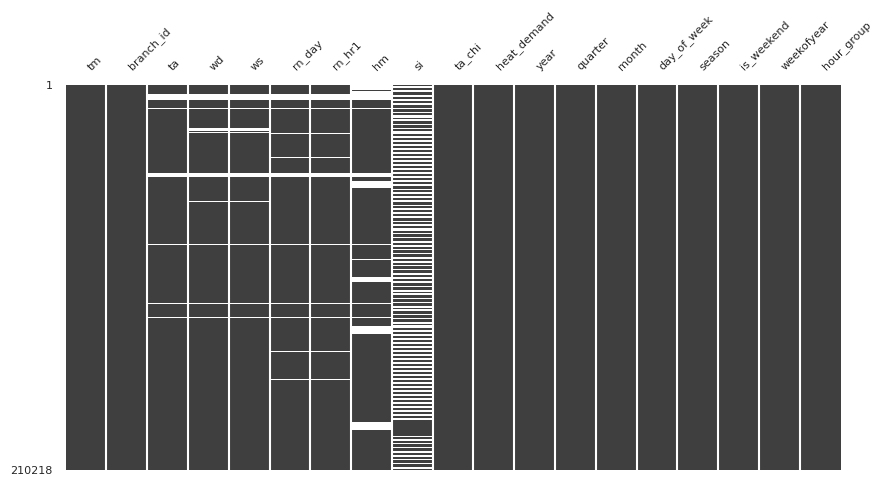

In [ ]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train_cluster0,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

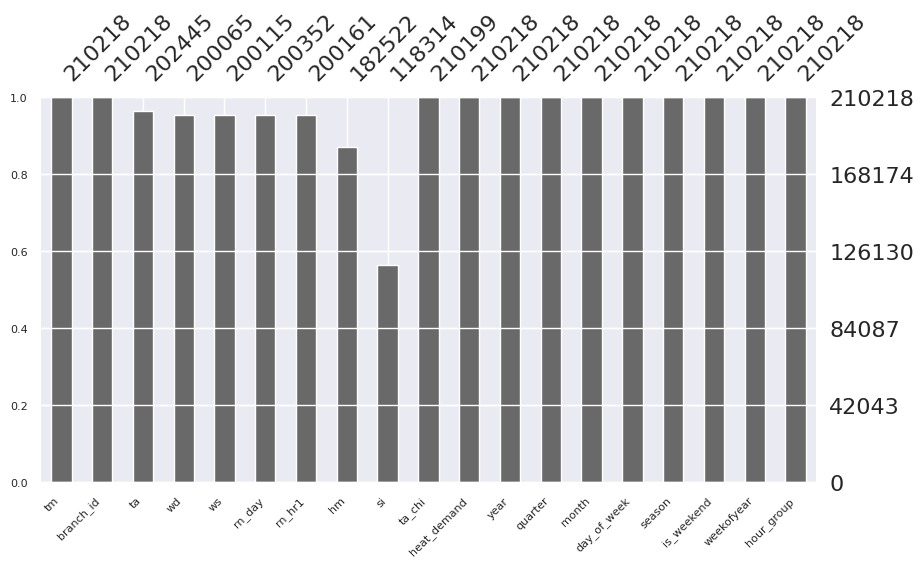

In [ ]:
# 막대그래프 형태로 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df_train_cluster0, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

### **1) Target 분석**

##### **(1) 일별 열수요 평균**

In [ ]:
daily_avg_df_cluster0 = (
    df_train_cluster0.copy()
    .assign(date=lambda x: x['tm'].dt.date)
    .groupby('date')['heat_demand']
    .mean()
)

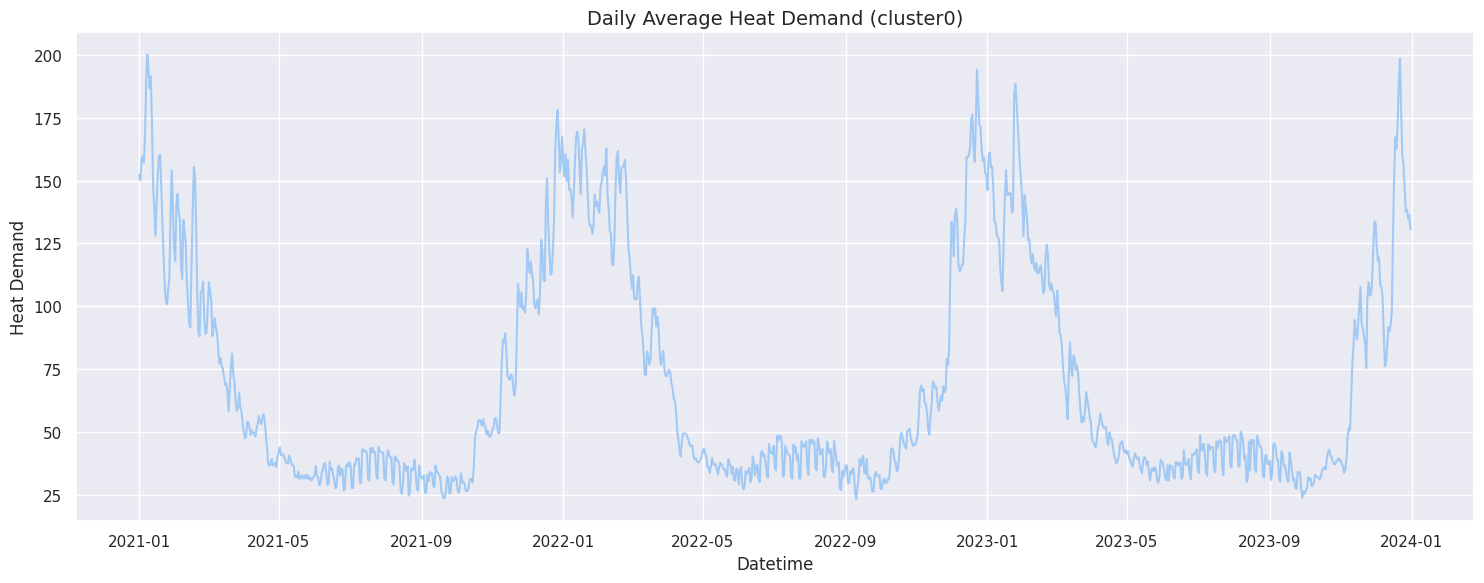

In [ ]:
# 시도표
plt.figure(figsize=(15, 6))
plt.plot(daily_avg_df_cluster0.index, daily_avg_df_cluster0.values)
plt.title('Daily Average Heat Demand (cluster0)', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Heat Demand', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##### **(2) 분포 시각화**

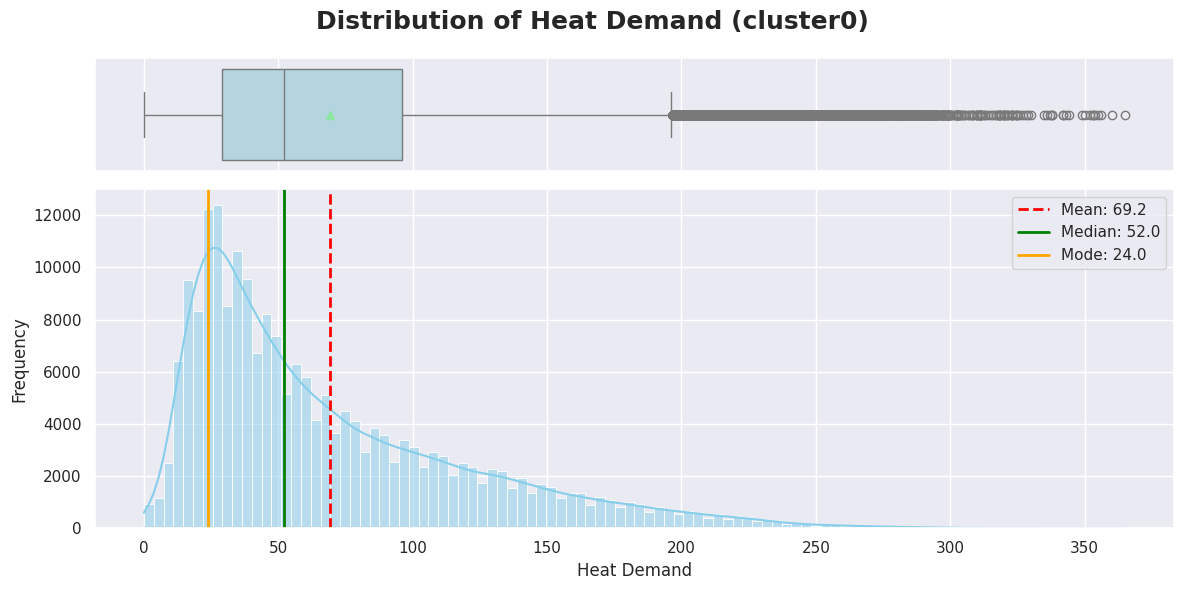

In [ ]:
# 평균, 중앙값, 최빈값 계산
mean = df_train_cluster0['heat_demand'].mean()
median = df_train_cluster0['heat_demand'].median()
mode = df_train_cluster0['heat_demand'].mode()[0]

# 서브플롯 구성 (상단: 박스플롯 / 하단: 히스토그램+분포)
fig, (ax_box, ax_hist) = plt.subplots(
    2, 1,
    gridspec_kw={"height_ratios": (.25, .75)},
    figsize=(12, 6),
    sharex=True
)

fig.suptitle("Distribution of Heat Demand (cluster0)", fontsize=18, fontweight='bold')

# (1) Boxplot
sns.boxplot(
    x=df_train_cluster0['heat_demand'],
    showmeans=True,
    orient='h',
    color='lightblue',
    ax=ax_box
)
ax_box.set(xlabel='')

# (2) Histogram + 평균/중앙값/최빈값 선
sns.histplot(df_train_cluster0['heat_demand'], bins=100, kde=True, color='skyblue', ax=ax_hist)
ax_hist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
ax_hist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.1f}')
ax_hist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.1f}')

# 축 및 범례
ax_hist.set_xlabel('Heat Demand', fontsize=12)
ax_hist.set_ylabel('Frequency', fontsize=12)
ax_hist.grid(True)
ax_hist.legend()

plt.tight_layout()
plt.show()



> 오른쪽으로 꼬리가 긴 분포를 가지며, 비대칭적인 분포를 보임 -> 분포의 왜도를 줄일 수 있는 **로그 변환, 또는 Box-Cox 변환**을 고려하자!



* 이상치 파악해보기

In [ ]:
# 이상치 기준 설정
threshold = 350

# 이상치 탐색
outliers = df_train_cluster0[df_train_cluster0['heat_demand'] >= threshold]

# 결과 출력
outliers.sort_values('heat_demand', ascending=False)

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day_of_week,season,is_weekend,weekofyear,hour_group
341797,2021-01-08 21:00:00,N,-10.0,245.8,2.4,0.0,0.0,NaN,NaN,-9.9,365.0,2021,1,1,4,Winter,Weekday,1,7
341796,2021-01-08 20:00:00,N,-9.8,221.2,2.7,0.0,0.0,NaN,NaN,-9.2,360.0,2021,1,1,4,Winter,Weekday,1,6
341798,2021-01-08 22:00:00,N,-10.3,290.2,1.2,0.0,0.0,NaN,NaN,-10.8,356.0,2021,1,1,4,Winter,Weekday,1,7
341773,2021-01-07 21:00:00,N,-12.1,263.1,2.4,0.0,0.0,NaN,NaN,-14.4,355.0,2021,1,1,3,Winter,Weekday,1,7
341774,2021-01-07 22:00:00,N,-12.5,267.7,2.3,0.0,0.0,NaN,NaN,-11.6,354.0,2021,1,1,3,Winter,Weekday,1,7
359773,2023-01-27 21:00:00,N,-6.0,118.8,1.6,0.0,0.0,39.9,NaN,-5.1,353.0,2023,1,1,4,Winter,Weekday,4,7
341821,2021-01-09 21:00:00,N,-7.8,307.1,1.9,0.0,0.0,NaN,NaN,-10.6,353.0,2021,1,1,5,Winter,Weekend,1,7
341845,2021-01-10 21:00:00,N,-3.9,258.3,0.6,0.0,0.0,NaN,NaN,-5.9,352.0,2021,1,1,6,Winter,Weekend,1,7
341772,2021-01-07 20:00:00,N,-11.6,268.3,3.4,0.0,0.0,NaN,NaN,-14.9,350.0,2021,1,1,3,Winter,Weekday,1,6




> N 지역의 2021년도 1월 7일 ~ 10일 사이로, 연속된 날들인 것을 봤을 때 이상치는 아닌 거 같음. 그대로 둬도 괜찮겠다는 생각입니다.


* 로그 변환 후 분포 재시각화

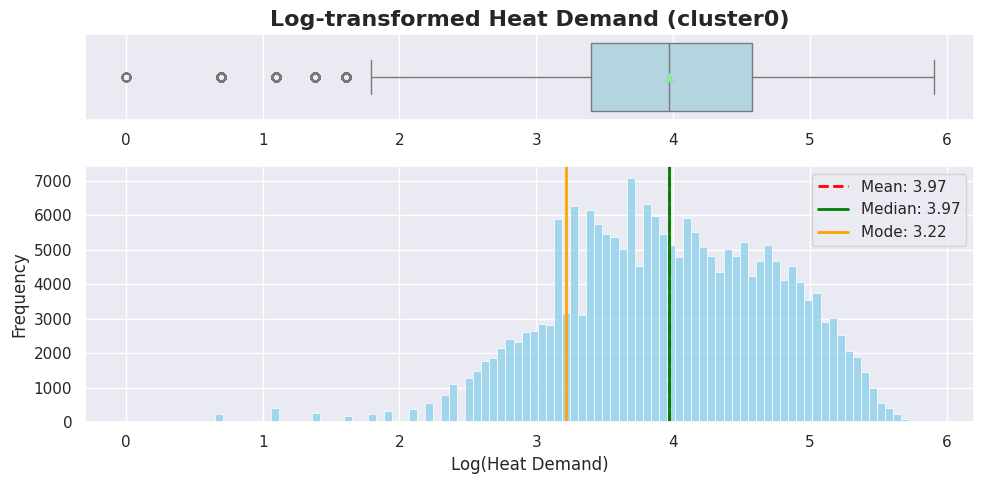

In [ ]:
df_train_cluster0['log_heat_demand'] = np.log1p(df_train_cluster0['heat_demand'])  # log(1 + x) 변환

# 시각화
fig, (ax_box, ax_dist) = plt.subplots(2, 1, gridspec_kw={"height_ratios": (.25, .75)}, figsize=(10, 5))

# 로그값에 대한 통계값
mean = df_train_cluster0['log_heat_demand'].mean()
median = df_train_cluster0['log_heat_demand'].median()
mode = df_train_cluster0['log_heat_demand'].mode().iloc[0]

# Boxplot
sns.boxplot(x=df_train_cluster0['log_heat_demand'], showmeans=True, orient='h', color='lightblue', ax=ax_box)
ax_box.set(xlabel='')
ax_box.set_title("Log-transformed Heat Demand (cluster0)", fontsize=16, fontweight='bold')

# Histogram
sns.histplot(df_train_cluster0['log_heat_demand'], bins=100, kde=False, ax=ax_dist, color='skyblue')
ax_dist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
ax_dist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
ax_dist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.2f}')
ax_dist.set_xlabel('Log(Heat Demand)', fontsize=12)
ax_dist.set_ylabel('Frequency', fontsize=12)
ax_dist.legend()

plt.tight_layout()
plt.show()



> 로그 변환을 통해 열수요 분포의 왜도가 완화됨. 로그 변환 후에도 소수의 이상치가 보이지만, 이는 극단적인 열수요 부족(0 근처의 값들)인 값들을 로그변환 해서 0에 가까운 값이 나온 것으로 보임(이상치로 생각하지 않아도 될 것 같음)



##### **(3) 주별 / 월별 / 년도별 / 요일별 / 계절별 / 주말 여부 열수요 평균**

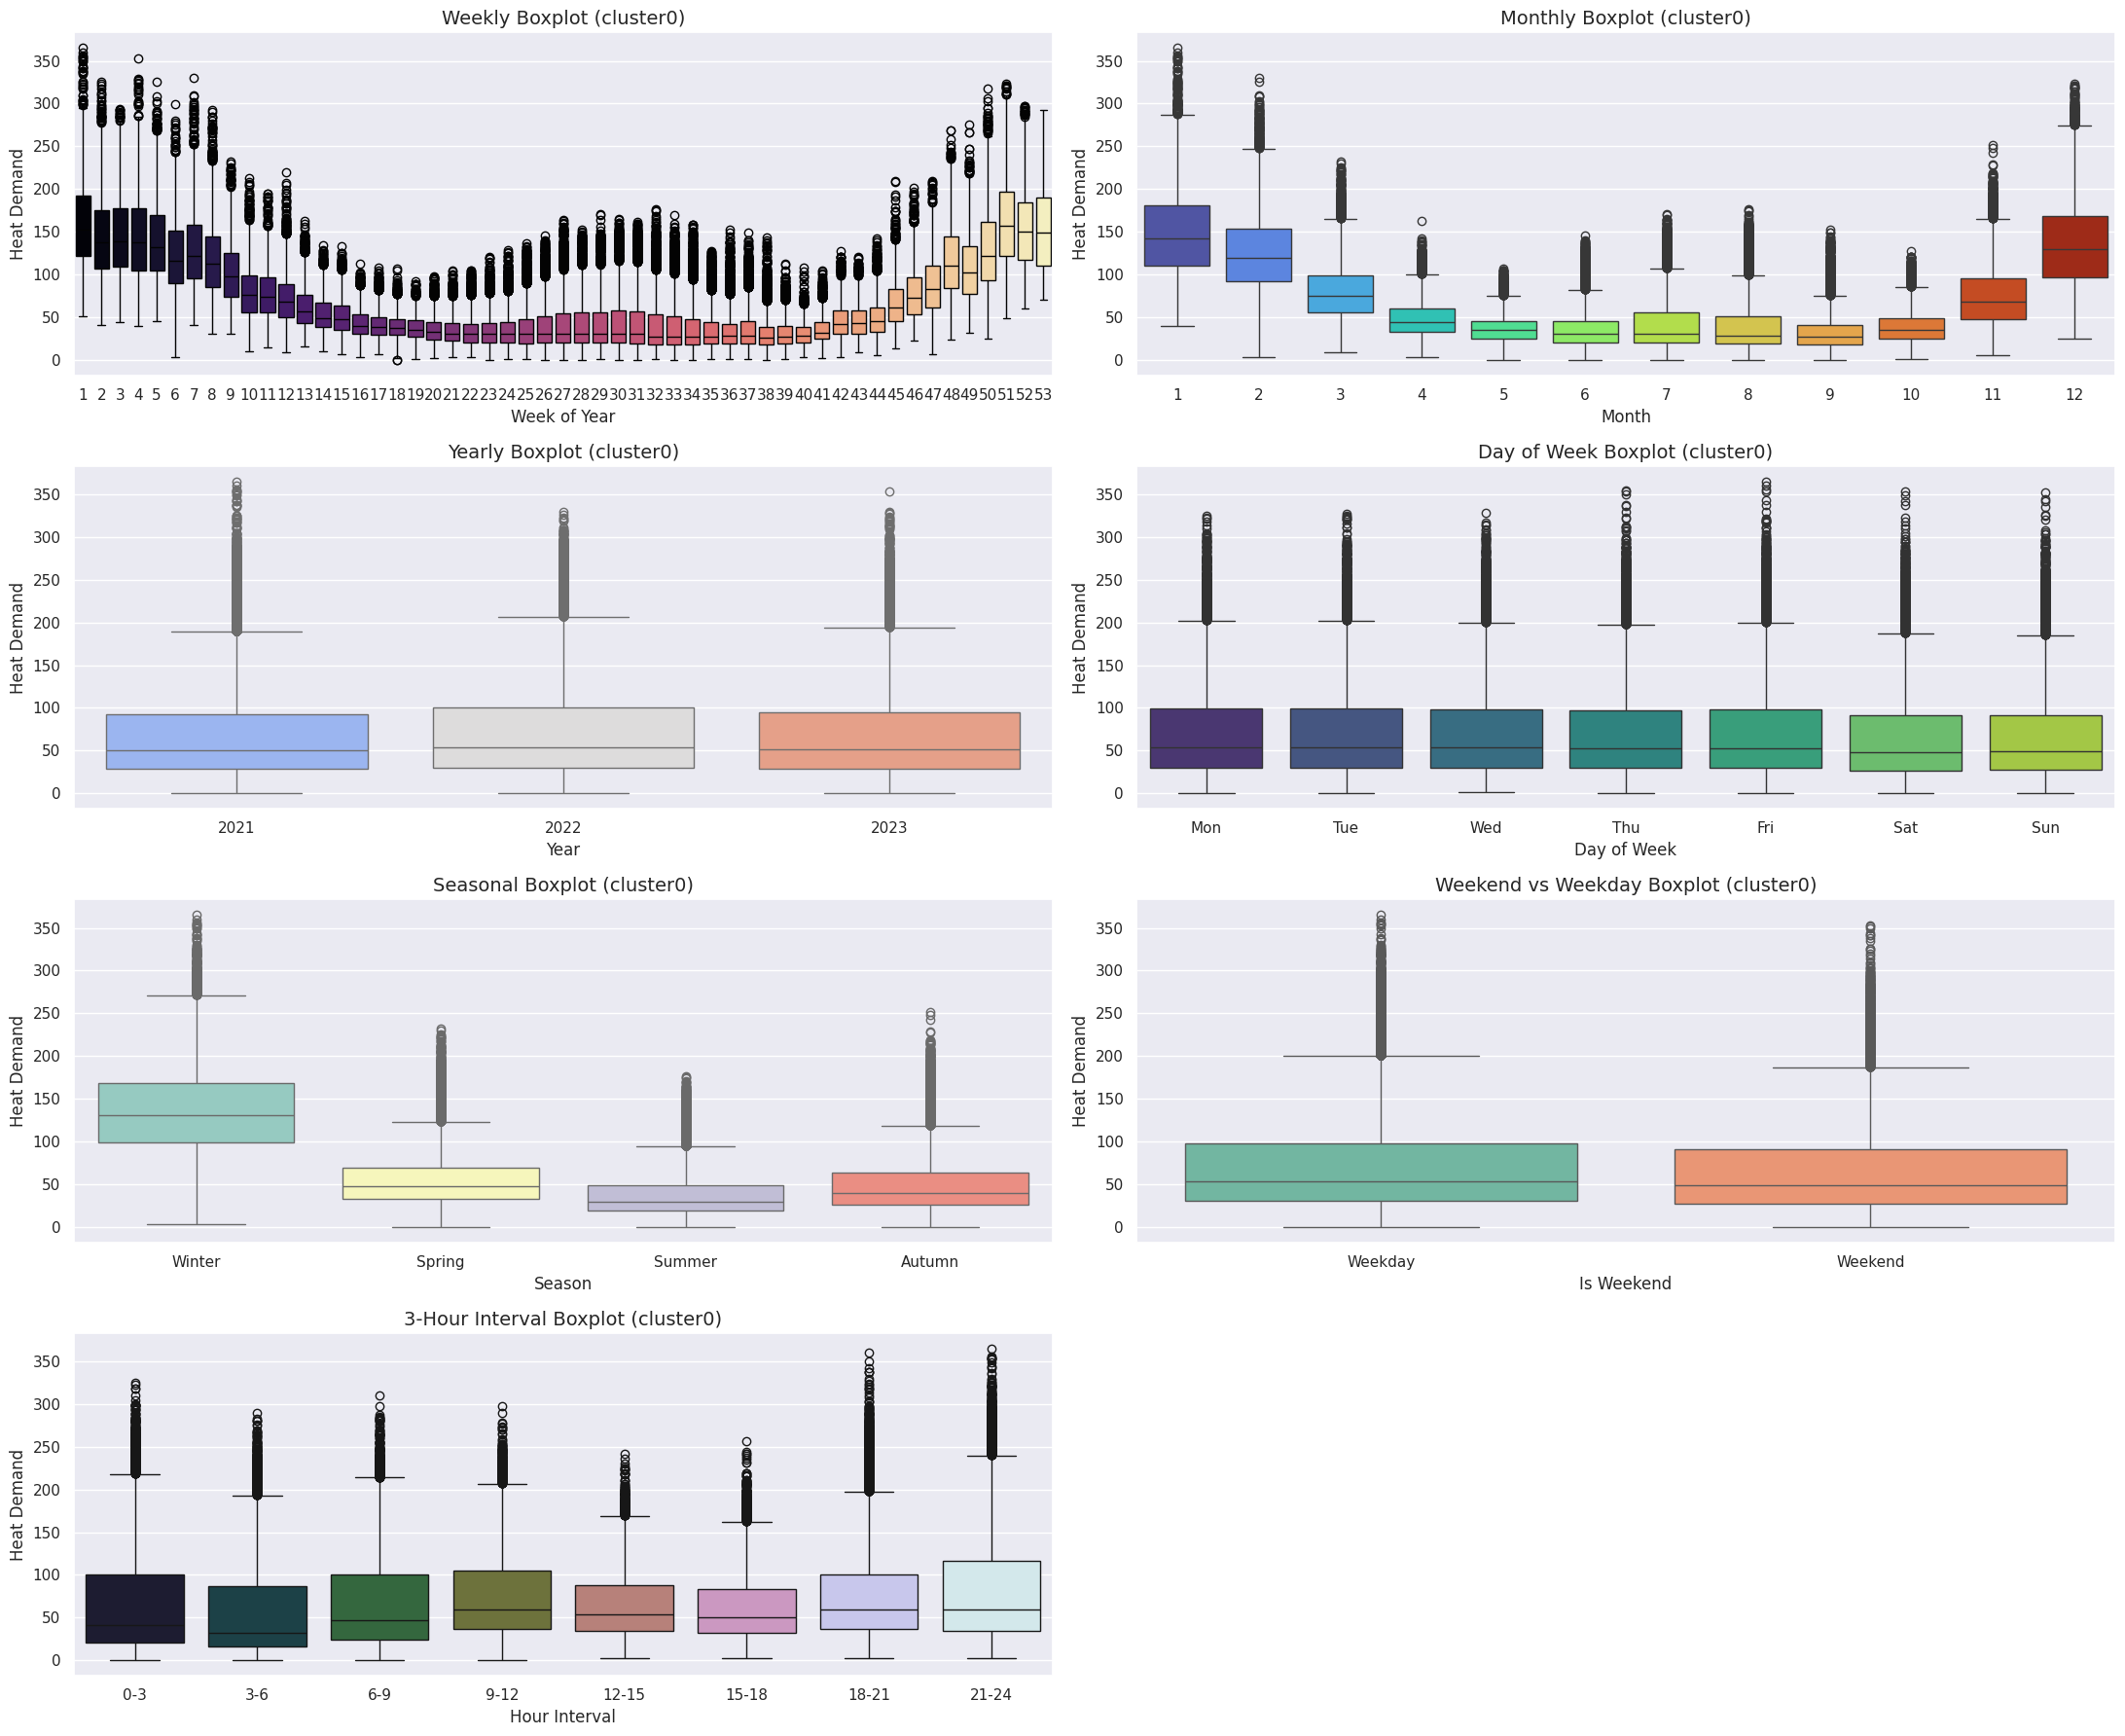

In [ ]:
# 요일 이름 매핑
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# 플롯 설정
fig, axes = plt.subplots(4, 2, figsize=(22, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# 1. 주별
sns.boxplot(x='weekofyear', y='heat_demand', data=df_train_cluster0, ax=axes[0,0], palette='magma')
axes[0,0].set_title('Weekly Boxplot (cluster0)', fontsize=14)
axes[0,0].set_xlabel('Week of Year')
axes[0,0].set_ylabel('Heat Demand')

# 2. 월별
sns.boxplot(x='month', y='heat_demand', data=df_train_cluster0, ax=axes[0,1], palette='turbo')
axes[0,1].set_title('Monthly Boxplot (cluster0)', fontsize=14)
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Heat Demand')

# 3. 연도별
sns.boxplot(x='year', y='heat_demand', data=df_train_cluster0, ax=axes[1,0], palette='coolwarm')
axes[1,0].set_title('Yearly Boxplot (cluster0)', fontsize=14)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Heat Demand')

# 4. 요일별
sns.boxplot(x='day_of_week', y='heat_demand', data=df_train_cluster0, ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Day of Week Boxplot (cluster0)', fontsize=14)
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Heat Demand')
axes[1,1].set_xticklabels(weekday_labels)

# 5. 계절별
sns.boxplot(x='season', y='heat_demand', data=df_train_cluster0, ax=axes[2,0], palette='Set3')
axes[2,0].set_title('Seasonal Boxplot (cluster0)', fontsize=14)
axes[2,0].set_xlabel('Season')
axes[2,0].set_ylabel('Heat Demand')

# 6. 주말여부
sns.boxplot(x='is_weekend', y='heat_demand', data=df_train_cluster0, ax=axes[2,1], palette='Set2')
axes[2,1].set_title('Weekend vs Weekday Boxplot (cluster0)', fontsize=14)
axes[2,1].set_xlabel('Is Weekend')
axes[2,1].set_ylabel('Heat Demand')

# 7. 하루를 3시간 단위로 나눈 박스플롯
sns.boxplot(x='hour_group', y='heat_demand', data=df_train_cluster0, ax=axes[3,0], palette='cubehelix')
axes[3,0].set_title('3-Hour Interval Boxplot (cluster0)', fontsize=14)
axes[3,0].set_xlabel('Hour Interval')
axes[3,0].set_ylabel('Heat Demand')
axes[3,0].set_xticklabels(hour_labels)

axes[3,1].axis('off')  # 일단 비워둠

plt.tight_layout()
plt.show()



> Weekly : 1 ~ 8 주와 48 ~ 53 주에 열수요가 매우 높고 여름철인 20~35주 사이에 열수요가 뚜렷하게 낮다. 또한, 이 시기에 분산의 크기도 크다. 이는 계절에 따라 난방 수요가 반영된 패턴임을 알 수 있음 (겨울철 수요 증가, 여름철 수요 감소)

> Monthly : 1, 2, 11, 12월에 수요가 높고, 6~9월에 가장 낮음.


> Yearly,Day of week, 주말 여부 : 뚜렷한 차이 없음

> Seasonal : 겨울은 수요 중앙값이 크고 변동성도 큼. Monthly와 비슷한 경향

> 3시간 단위 : 9-12가 가장 높음


* 계절별 시간대별 (3시간 간격) Boxplot

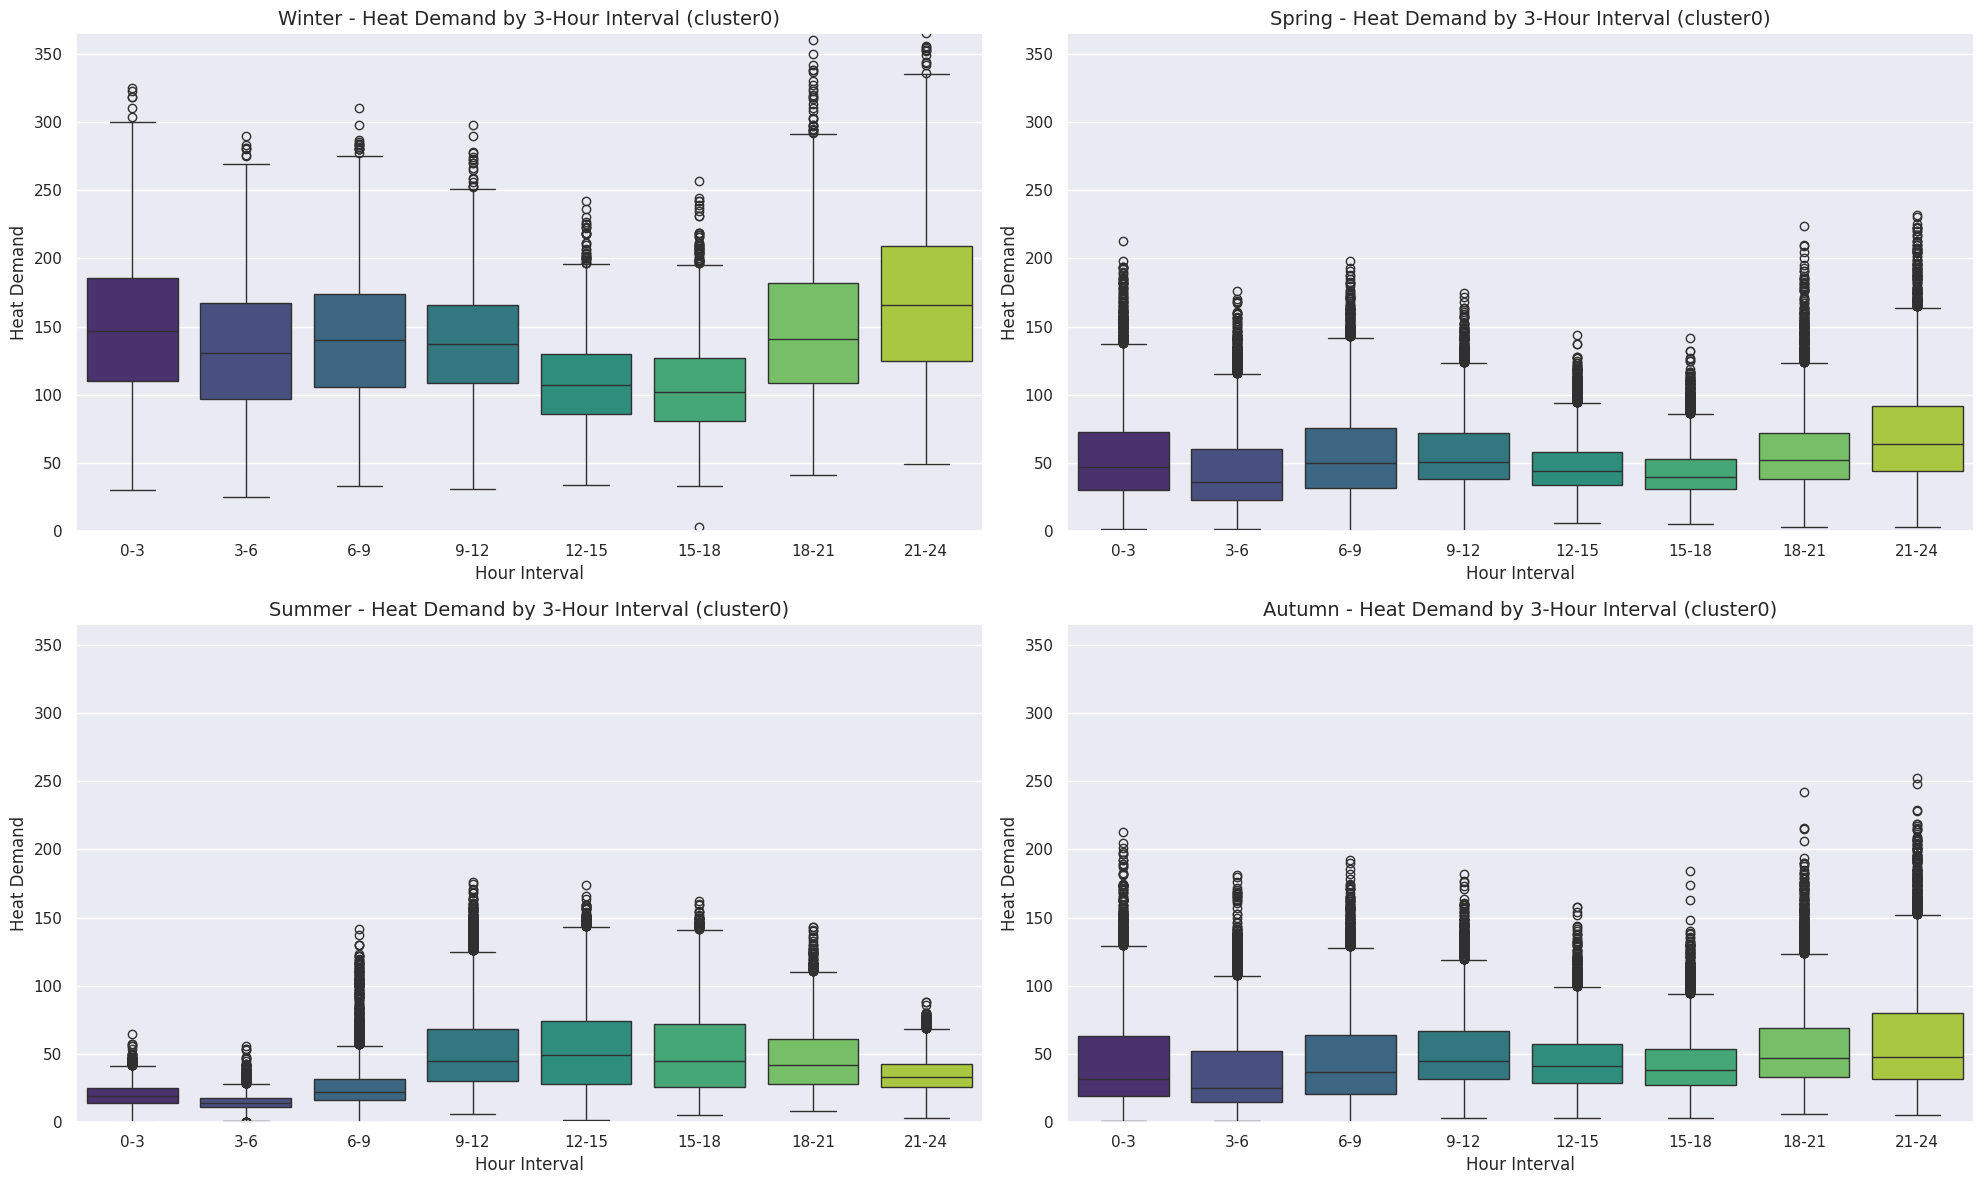

In [ ]:
# 3시간 단위 시간 그룹 레이블
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
df_train_cluster0['hour_group'] = (df_train_cluster0['tm'].dt.hour // 3).astype(int)

# 계절 순서 고정
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# 공통 y축 범위 지정
y_min = 0
y_max = df_train_cluster0['heat_demand'].max()

# 시각화
plt.figure(figsize=(20, 12))
for i, season in enumerate(season_order):
    plt.subplot(2, 2, i+1)
    subset = df_train_cluster0[df_train_cluster0['season'] == season]
    sns.boxplot(x='hour_group', y='heat_demand', data=subset, palette='viridis')
    plt.title(f'{season} - Heat Demand by 3-Hour Interval (cluster0)', fontsize=14)
    plt.xlabel('Hour Interval')
    plt.ylabel('Heat Demand')
    plt.xticks(ticks=range(8), labels=hour_labels)
    plt.ylim(y_min, y_max)  # Y축 고정

plt.tight_layout()
plt.show()


> winter: 전 시간대에서 열수요가 전반적으로 높으며, 특히 18-21시, 21-24시 구간에서 수요가 가장 높다. 이는 특히 온도가 낮은 저녁, 밤 시간대의 영향인 것으로 보인다.

> spring : 요가 다소 줄어들지만, 아침 시간대(6–9시, 9–12시)와 저녁~밤 시간대(18–21시, 21–24시)에 다시 상승 → 출근 전 준비 시간대와 귀가 후 활동 시간대에 난방 사용이 이루어지는 경향으로 해석 가능


> **summer** : 전체 수요는 가장 낮지만, 낮 시간대(9–12시, 12–15시)에 수요가 상대적으로 높음. → 일반 건물에서 난방 수요가 적은 시기이므로, 다음과 같은 가능성이 존재: (1) 산업/상업 부문의 공정용 열수요: 공장 가동 시 사용되는 증기/열교환 시스템 등 (2) 냉방 보조 시스템 수요: 예를 들어 흡수식 냉방기는 여름 냉방을 위해 열을 소모함. 낮에 냉방 피크가 몰리므로 열수요도 동반 상승했을 가능

> autumn : 전반적으로 균일한 수요를 보임

* 브랜치별로 3시간 단위 파악

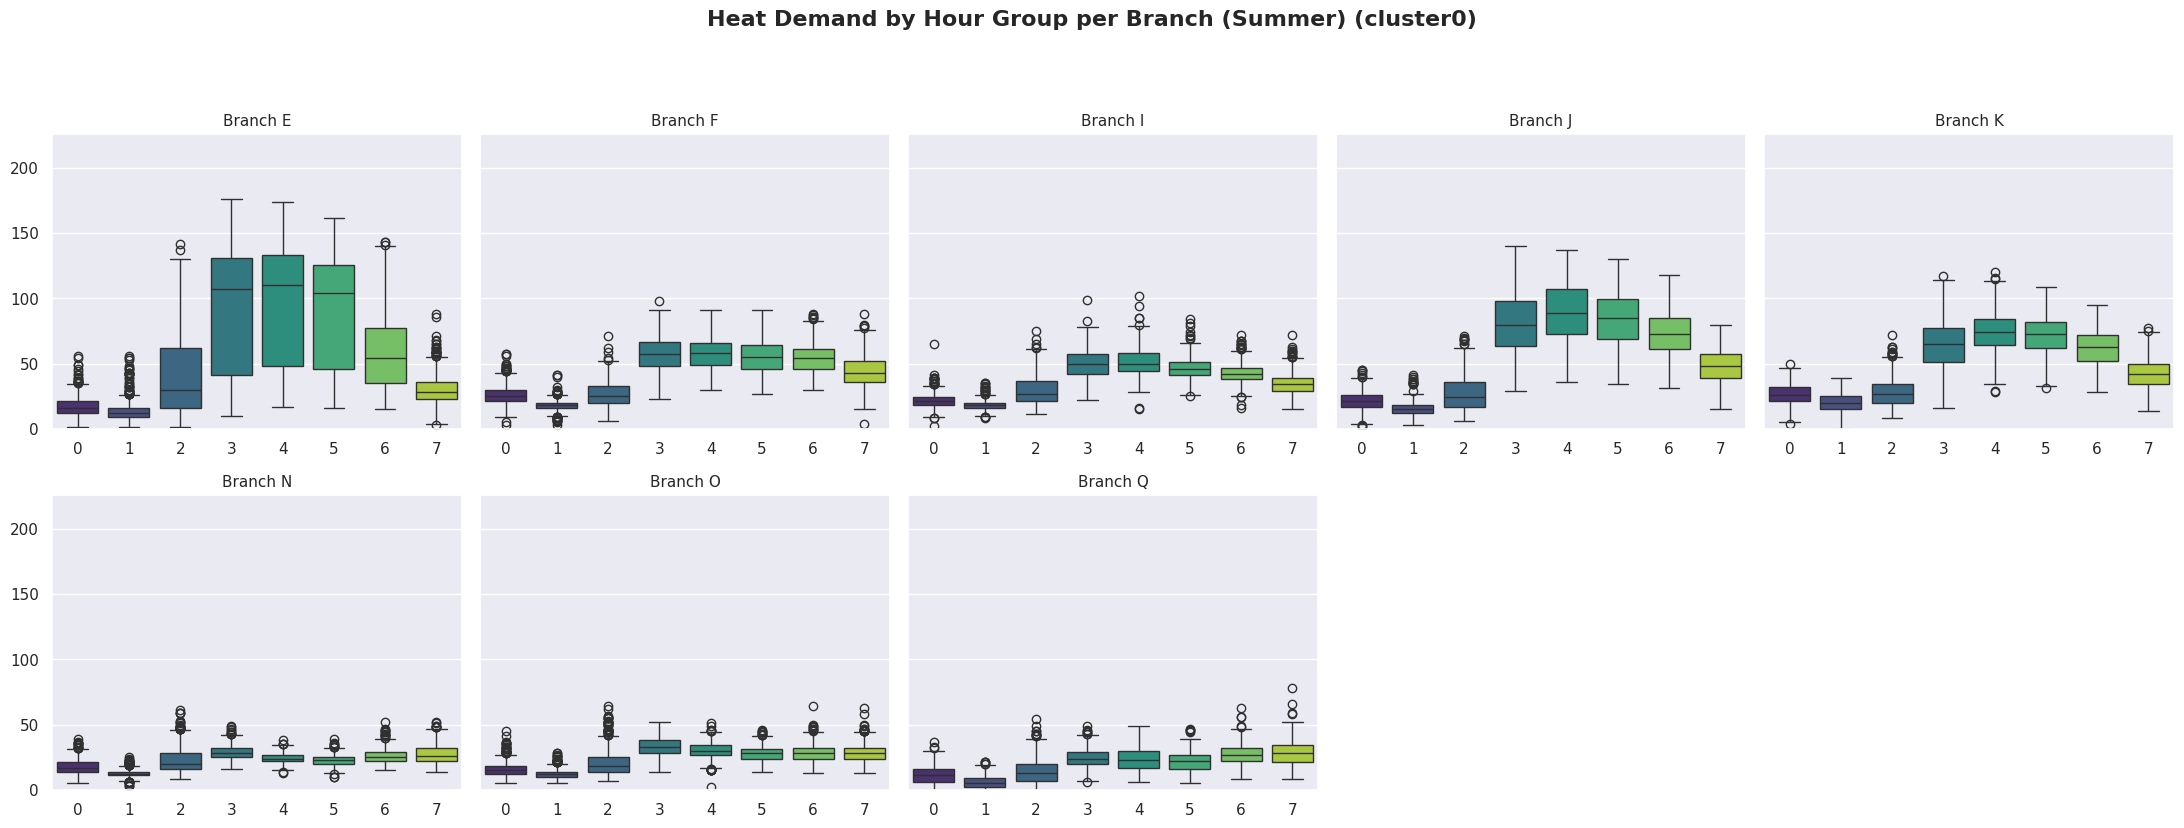

In [ ]:
# 여름철 데이터 필터링
summer_df = df_train_cluster0[df_train_cluster0['month'].isin([6, 7, 8])]

# 브랜치 정렬
branches = sorted(summer_df['branch_id'].unique())
n_branches = len(branches)

# 공통 y축 범위 설정
y_min = summer_df['heat_demand'].min()
y_max = summer_df['heat_demand'].max() + 50

# subplot 설정
n_rows, n_cols = 4, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 16), sharey=True)  # sharey로 Y축 일치
axes = axes.flatten()

# 각 지점에 대해 boxplot 그리기
for i, branch in enumerate(branches):
    ax = axes[i]
    branch_df = summer_df[summer_df['branch_id'] == branch]
    sns.boxplot(data=branch_df, x='hour_group', y='heat_demand', ax=ax, palette='viridis')
    ax.set_title(f'Branch {branch}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(y_min, y_max)  # 모든 서브플롯에 동일한 y축 설정

# 남는 subplot은 비활성화
for j in range(len(branches), len(axes)):
    fig.delaxes(axes[j])

# 전체 레이아웃 조정
plt.suptitle('Heat Demand by Hour Group per Branch (Summer) (cluster0)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



> Cluster 0에 속한 지사들은 여름철에도 일정 수준 이상의 열수요를 보이는 특징이 있다. 시간대별 수요 분포는 지사마다 뚜렷하게 다르며, 열 사용 패턴이 다양하게 나타난다.

> 일부 지사(E, F, J)는 **낮 시간대(9~18시)**에 열수요가 집중되는 뚜렷한 피크를 보인다.

> N, O 지사는 여름철 전반적으로 열 사용량이 매우 낮아 비활성에 가까운 모습을 보인다. (낮의 사용량이 클러스터 내 다른 브랜치에 비해 적은 편이다.)


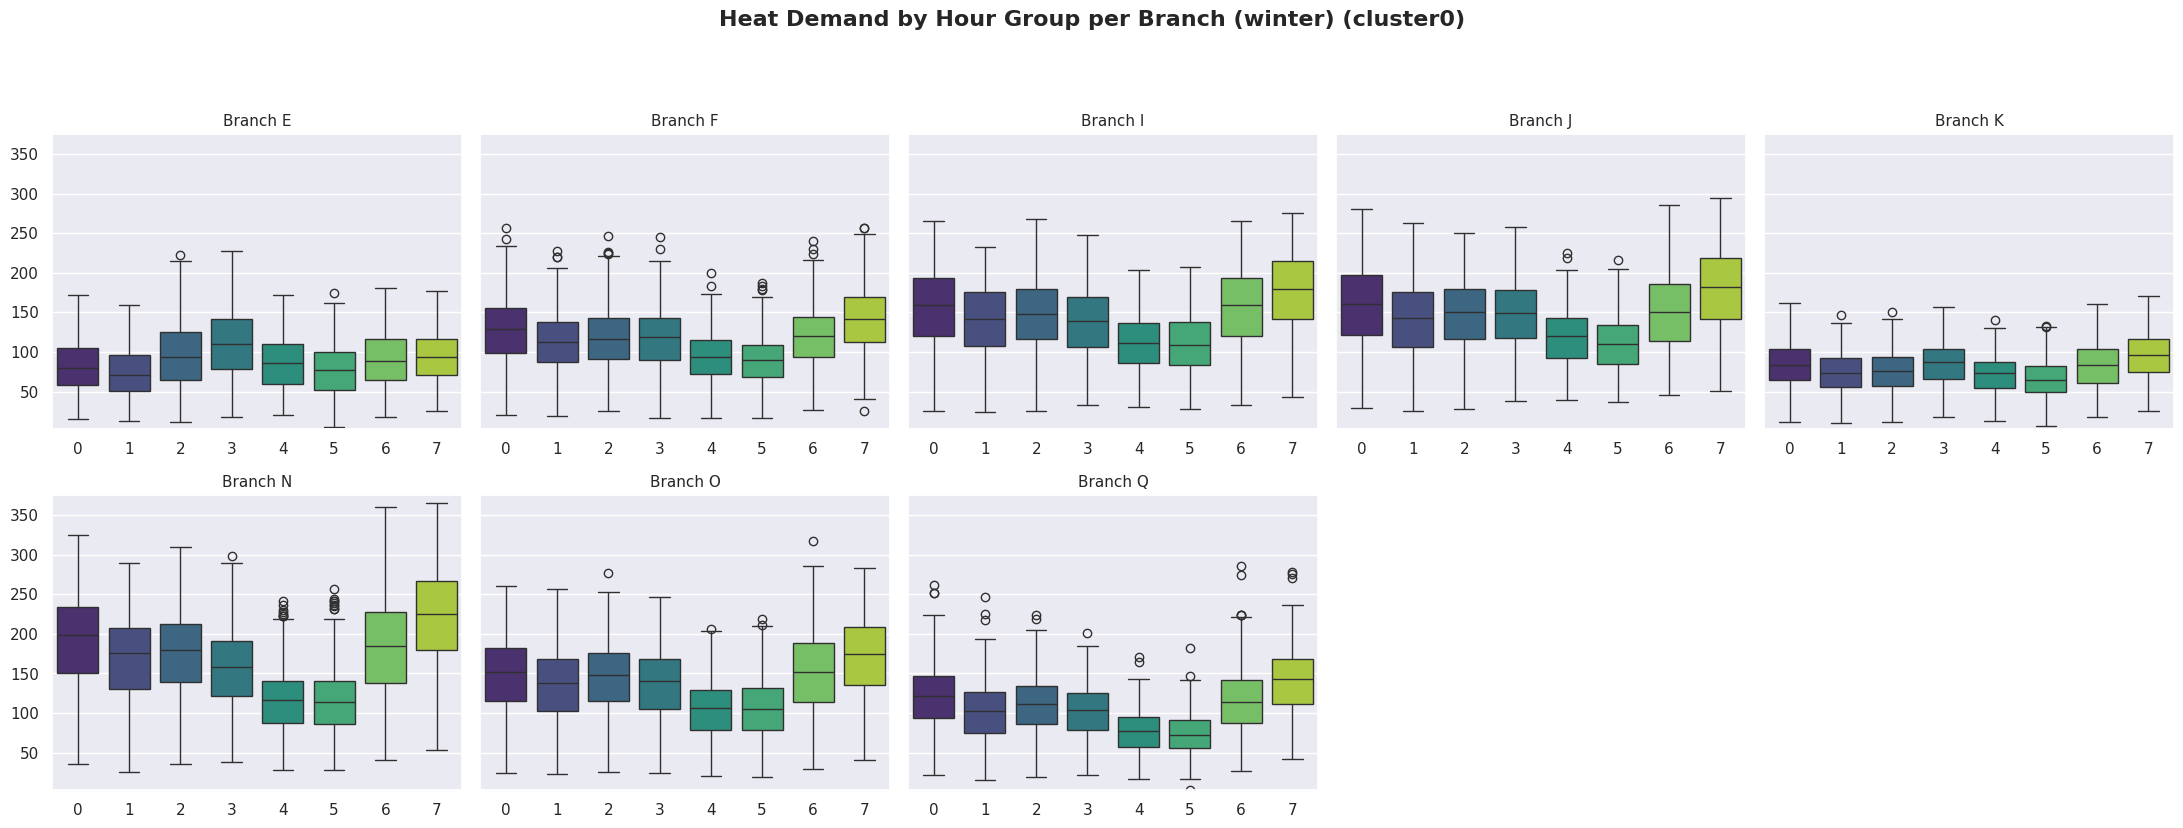

In [ ]:
# 겨울철 데이터 필터링
winter_df = df_train_cluster0[df_train_cluster0['month'].isin([11,12,1,2])]

# 브랜치 정렬
branches = sorted(winter_df['branch_id'].unique())
n_branches = len(branches)

# 공통 y축 범위 설정
y_min = winter_df['heat_demand'].min()
y_max = winter_df['heat_demand'].max() + 10

# subplot 설정
n_rows, n_cols = 4, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 16), sharey=True)  # sharey로 Y축 일치
axes = axes.flatten()

# 각 지점에 대해 boxplot 그리기
for i, branch in enumerate(branches):
    ax = axes[i]
    branch_df = winter_df[winter_df['branch_id'] == branch]
    sns.boxplot(data=branch_df, x='hour_group', y='heat_demand', ax=ax, palette='viridis')
    ax.set_title(f'Branch {branch}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(y_min, y_max)  # 모든 서브플롯에 동일한 y축 설정

# 남는 subplot은 비활성화
for j in range(len(branches), len(axes)):
    fig.delaxes(axes[j])

# 전체 레이아웃 조정
plt.suptitle('Heat Demand by Hour Group per Branch (winter) (cluster0)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




> branch별 시간대에 따른 차이가 크지 않다. Cluster 0 지사들은 겨울철 전반적으로 높은 열수요를 보이며, 시간대별 피크 양상이 지사마다 다르게 나타난다. 대부분의 지사에서 **저녁 시간대(18~24시)**에 열수요가 증가하는 경향이 공통적으로 관찰된다.




### **2-3) Feature 분석**


##### **(1) branch_id**

In [ ]:
df_train_cluster0.groupby('branch_id')['heat_demand'].describe()

,count,mean,std,min,25%,50%,75%,max
branch_id,,,,,,,,
E,26270.0,58.333689,40.510389,0.0,26.0,45.0,87.0,227.0
F,26278.0,67.806378,42.540855,1.0,37.0,54.0,93.0,257.0
I,26279.0,77.364664,56.433210,2.0,36.0,53.0,112.0,275.0
J,26277.0,85.767515,54.627913,1.0,46.0,71.0,118.0,295.0
K,26278.0,52.653018,29.387538,0.0,28.0,47.0,73.0,171.0
N,26279.0,84.274820,72.145200,3.0,27.0,53.0,129.0,365.0
O,26278.0,71.502816,57.704600,2.0,27.0,45.0,109.0,317.0
Q,26279.0,55.578294,45.094550,0.0,22.0,37.0,83.0,286.0


* 지사별 열수요 분포

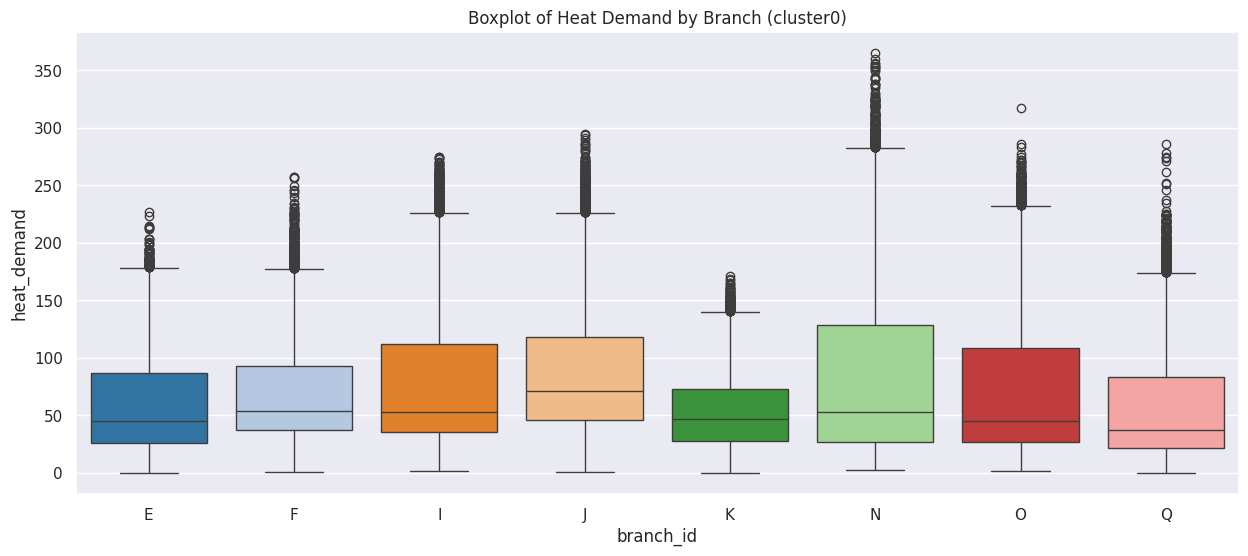

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='branch_id', y='heat_demand', data=df_train_cluster0, palette='tab20')
plt.title('Boxplot of Heat Demand by Branch (cluster0)')
plt.show()


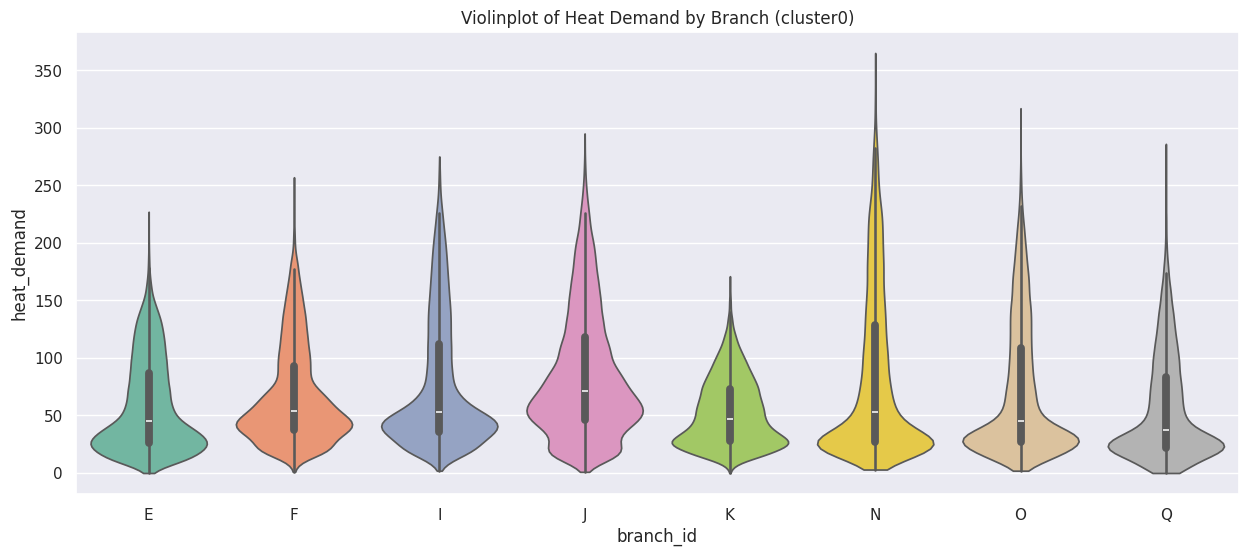

In [ ]:
plt.figure(figsize=(15,6))
sns.violinplot(x='branch_id', y='heat_demand', data=df_train_cluster0, palette='Set2', cut=0)
plt.title('Violinplot of Heat Demand by Branch (cluster0)')
plt.show()

* 브랜치별 시간에 따른 평균 열수요

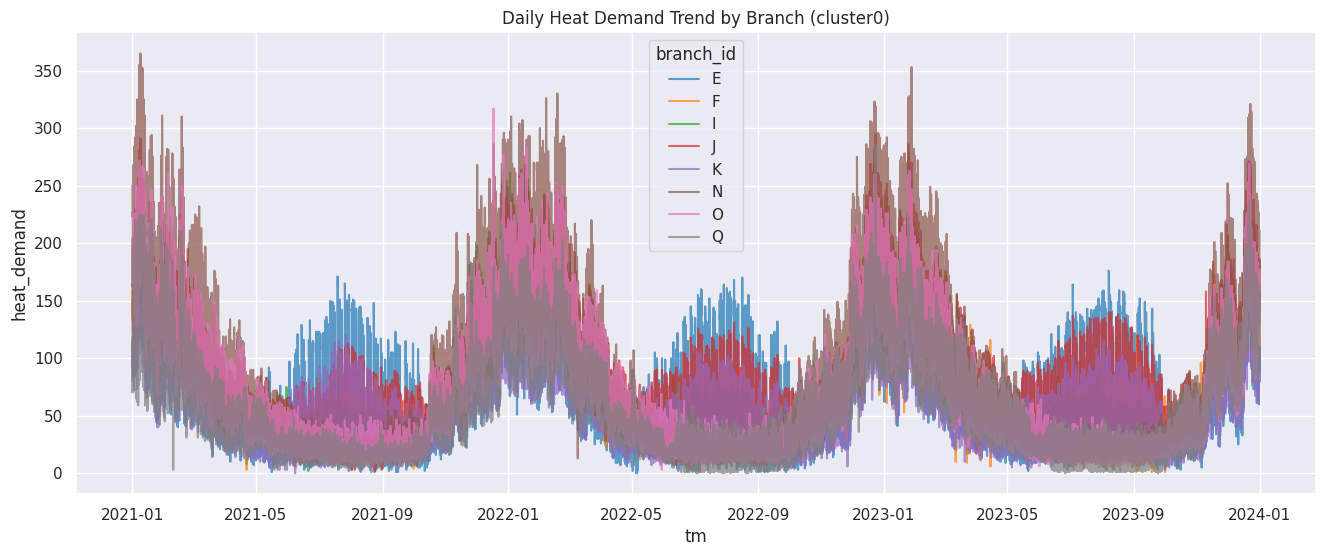

In [ ]:
daily_branch_avg = df_train_cluster0.groupby(['tm', 'branch_id'])['heat_demand'].mean().reset_index()
plt.figure(figsize=(16,6))
sns.lineplot(data=daily_branch_avg, x='tm', y='heat_demand', hue='branch_id', alpha=0.7, palette='tab10')
plt.title('Daily Heat Demand Trend by Branch (cluster0)')
plt.show()

* 브랜치별 열수요 상관관계 heatmap

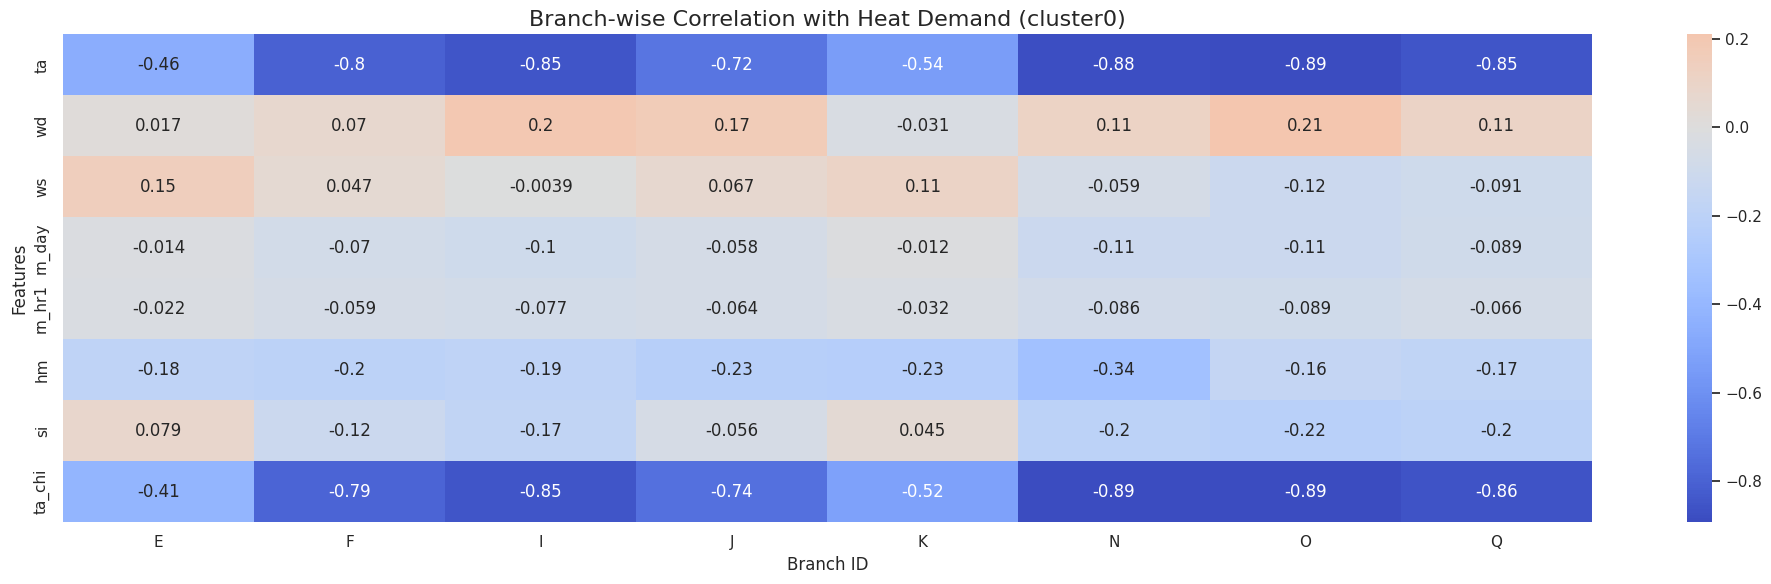

In [ ]:
numeric_features = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi']

corr_list = []
branch_ids = df_train_cluster0['branch_id'].unique()

for b in branch_ids:
    df_branch = df_train_cluster0[df_train_cluster0['branch_id'] == b]
    corr = df_branch[numeric_features + ['heat_demand']].corr()['heat_demand'].drop('heat_demand')
    corr_list.append(corr)

# 데이터프레임 형태로 변환
corr_df = pd.concat(corr_list, axis=1)
corr_df.columns = branch_ids

# 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=True)
plt.title('Branch-wise Correlation with Heat Demand (cluster0)', fontsize=16)
plt.xlabel('Branch ID')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

* 시간 (3시간 단위) x 지사별 열수요

Text(0.5, 0.98, 'Heat Demand by Hour Group per Branch (cluster0)')

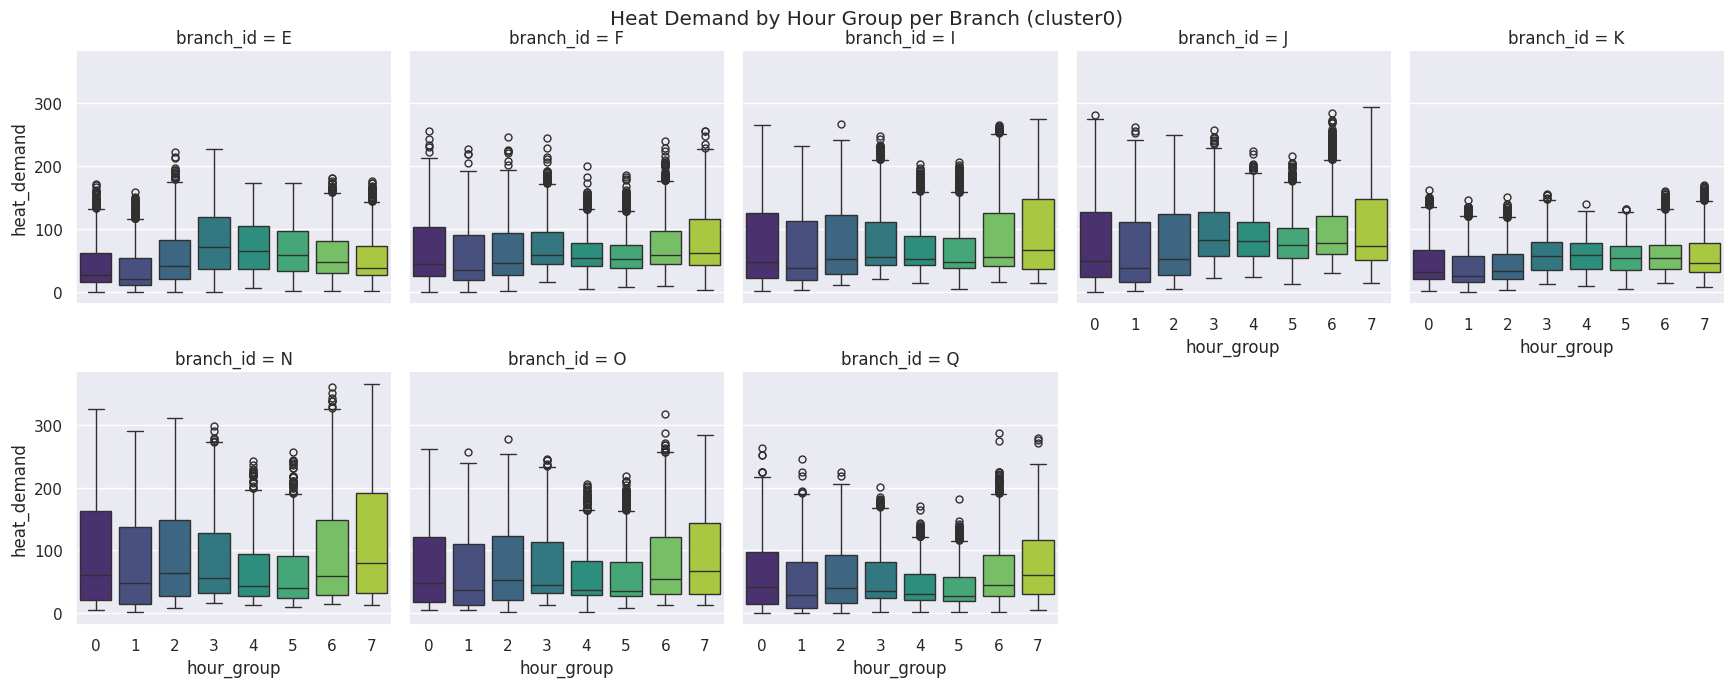

In [ ]:
g = sns.catplot(
    data=df_train_cluster0, kind='box',
    x='hour_group', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='viridis'
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Hour Group per Branch (cluster0)')

* 계절 x 지사별 열수요

Text(0.5, 0.98, 'Heat Demand by Season per Branch (cluster0)')

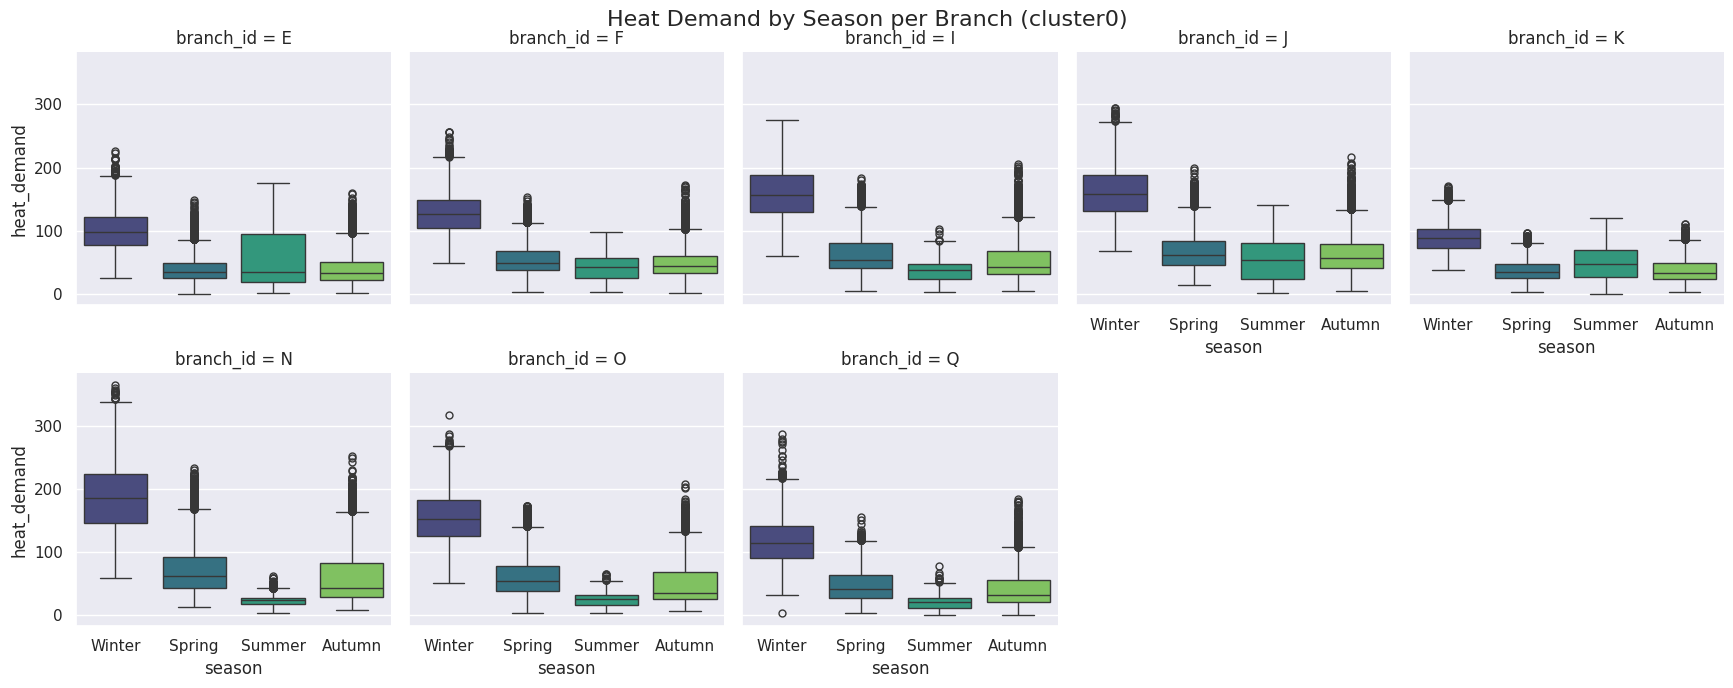

In [ ]:
# 계절 순서 명시 (선택사항: 기존에 설정 안 되어 있다면)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# 시각화
g = sns.catplot(
    data=df_train_cluster0, kind='box',
    x='season', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='viridis',
    order=season_order  # x축 계절 순서 지정
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Season per Branch (cluster0)', fontsize=16)

* 월별 x 지사별 열 수요

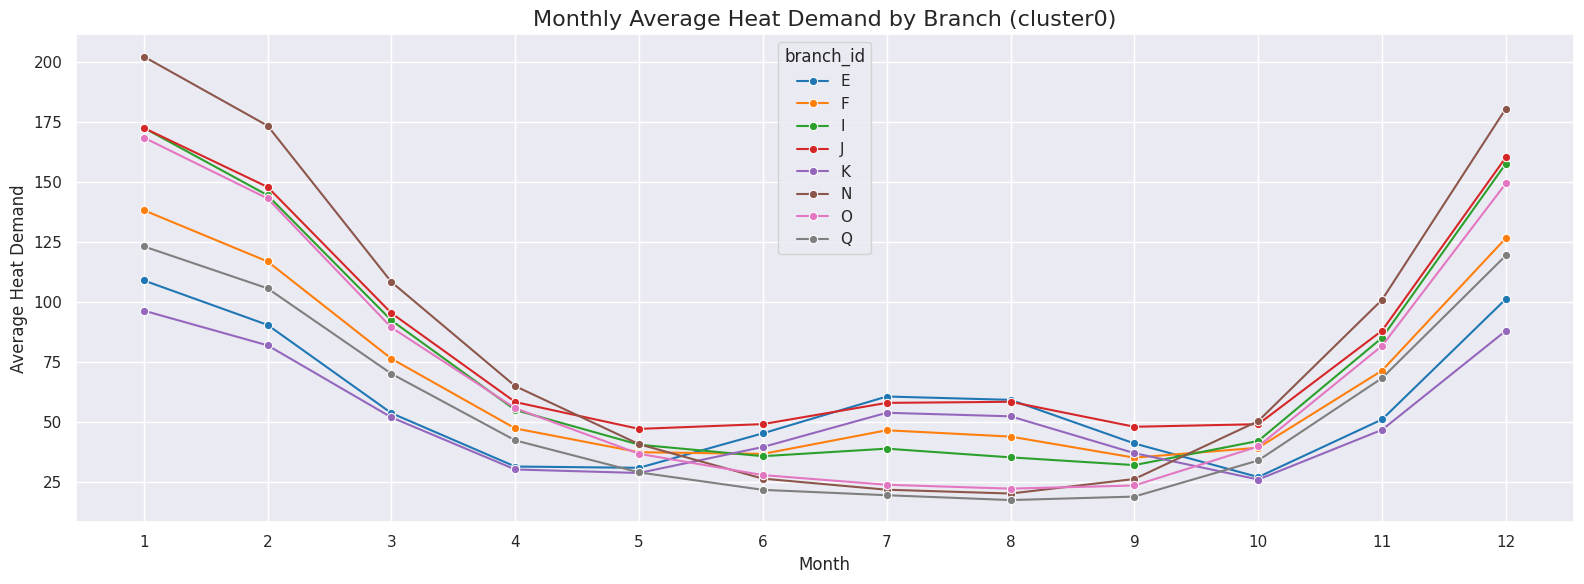

In [ ]:
# 월별 평균 열수요 계산
monthly_branch_avg = df_train_cluster0.groupby(['month', 'branch_id'])['heat_demand'].mean().reset_index()

# 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_branch_avg, x='month', y='heat_demand', hue='branch_id', marker='o', palette='tab10')
plt.title('Monthly Average Heat Demand by Branch (cluster0)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Heat Demand')
plt.xticks(ticks=range(1, 13))  # 1~12월 표시
plt.grid(True)
plt.tight_layout()
plt.show()


##### **(2) ta (기온)**

* 결측치

In [ ]:
# 결측치 개수 확인
null_count = df_train_cluster0['ta'].isnull().sum()
print(f"Missing values in 'ta': {null_count}")

# 전체 대비 비율 확인
total = len(df_train_cluster0)
print(f"Percentage of missing: {null_count / total:.2%}")

Missing values in 'ta': 7773
Percentage of missing: 3.70%


In [ ]:
# 결측치가 있는 행 살펴보기
df_train_cluster0[df_train_cluster0['ta'].isnull()]

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day_of_week,season,is_weekend,weekofyear,hour_group,log_heat_demand
106931,2021-03-17 20:00:00,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,31.0,2021,1,3,2,Spring,Weekday,11,6,3.465736
106932,2021-03-17 21:00:00,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9,41.0,2021,1,3,2,Spring,Weekday,11,7,3.737670
106933,2021-03-17 22:00:00,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.6,56.0,2021,1,3,2,Spring,Weekday,11,7,4.043051
106934,2021-03-17 23:00:00,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,32.0,2021,1,3,2,Spring,Weekday,11,7,3.496508
107449,2021-04-08 11:00:00,E,NaN,NaN,NaN,NaN,NaN,NaN,2.69,15.4,27.0,2021,2,4,3,Spring,Weekday,14,3,3.332205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423311,2021-04-30 11:00:00,Q,NaN,NaN,NaN,NaN,NaN,NaN,1.78,12.4,30.0,2021,2,4,4,Spring,Weekday,17,3,3.433987
425114,2021-07-14 14:00:00,Q,NaN,178.4,2.7,0.0,0.0,56.1,2.13,33.4,15.0,2021,3,7,2,Summer,Weekday,28,4,2.772589
432958,2022-06-06 10:00:00,Q,NaN,NaN,NaN,NaN,NaN,NaN,0.89,17.7,19.0,2022,2,6,0,Summer,Weekday,23,3,2.995732
436168,2022-10-18 04:00:00,Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,36.0,2022,4,10,1,Autumn,Weekday,42,1,3.610918


* 계절별 기온 / 월별 기온

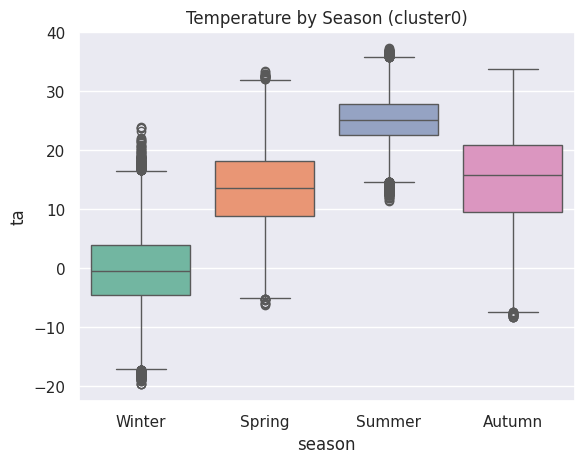

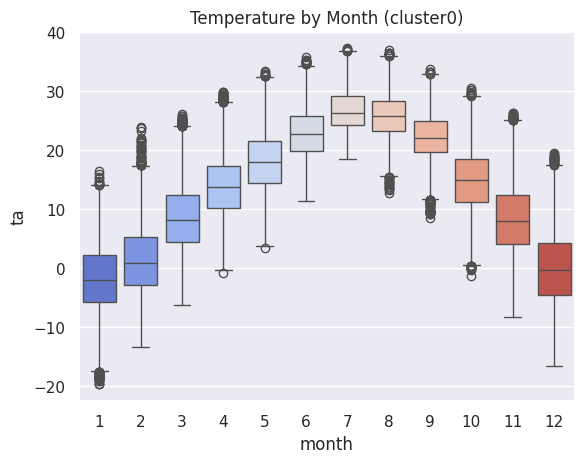

In [ ]:
# 계절별
sns.boxplot(x='season', y='ta', data=df_train_cluster0, palette='Set2', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Temperature by Season (cluster0)')
plt.show()

# 월별
sns.boxplot(x='month', y='ta', data=df_train_cluster0, palette='coolwarm')
plt.title('Temperature by Month (cluster0)')
plt.show()

* 기온과 열수요의 관계

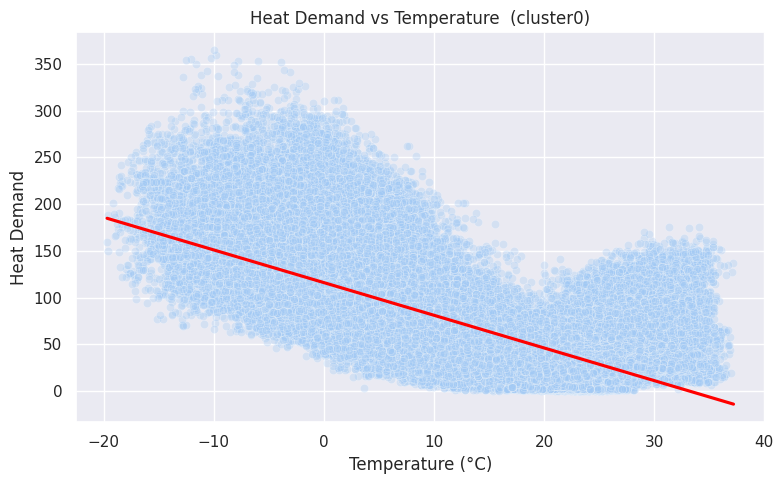

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='ta', y='heat_demand', data=df_train_cluster0, alpha=0.3)
sns.regplot(x='ta', y='heat_demand', data=df_train_cluster0, scatter=False, color='red')
plt.title('Heat Demand vs Temperature  (cluster0)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

* 지점별 기온과 열수요 관계

Text(0.5, 0.98, 'Heat Demand vs Temperature by Branch (cluster0)')

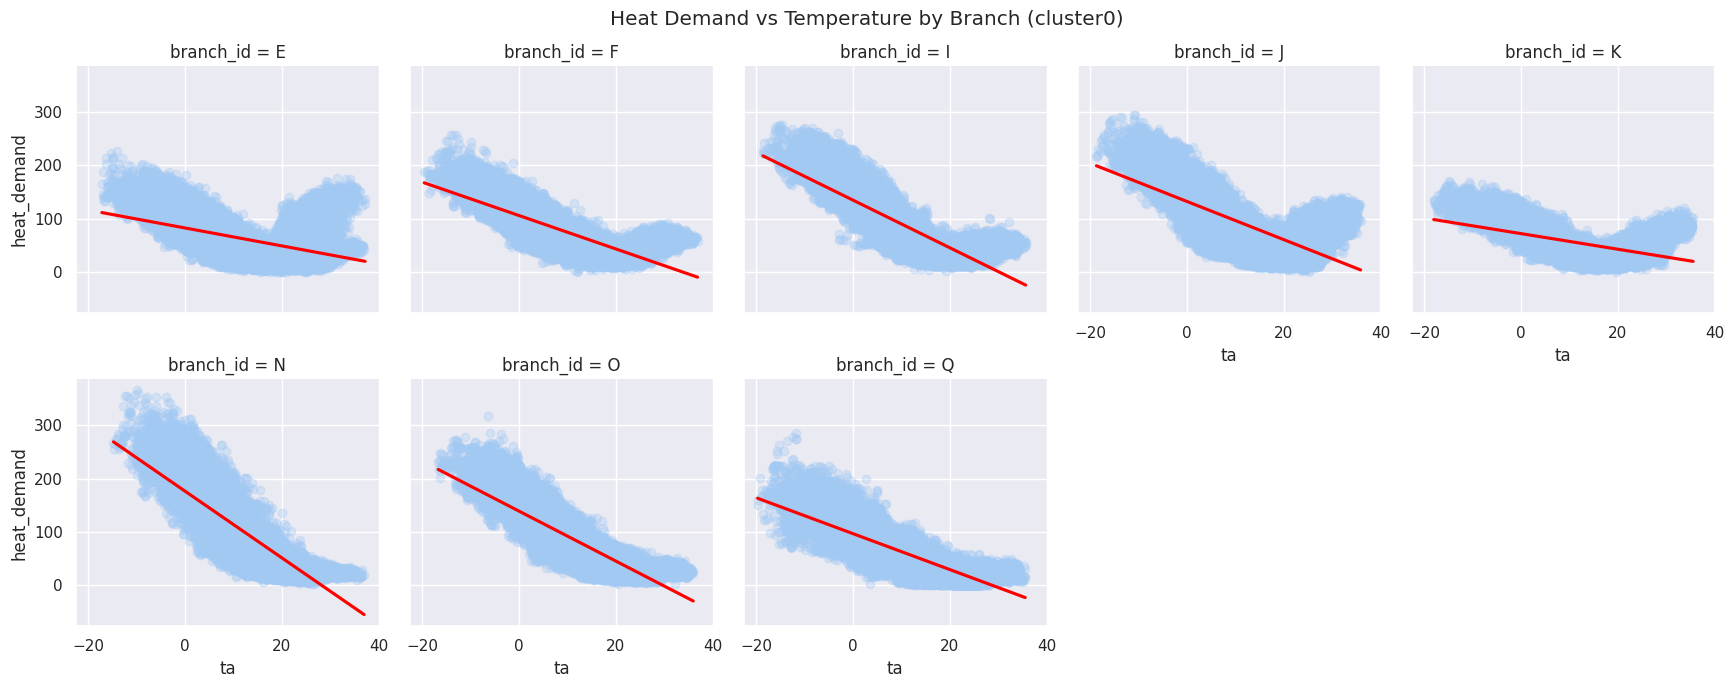

In [ ]:
g = sns.lmplot(data=df_train_cluster0, x='ta', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Temperature by Branch (cluster0)')

##### **(3) wd (풍향)**

풍향 변수는 범주형 변수로 다룰 수도 있고, 연속 각도 변수로 다룰 수도 있음

+ 풍향은 주기를 가지기 때문에 sin, cos 변환을 고려해도 됨

* 범주형 변수인 경우

In [ ]:
def wind_direction_category(deg):
    if pd.isna(deg):
        return 'Unknown'  # 또는 np.nan
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    return directions[int((deg % 360) / 45)]

df_train['wd_cat'] = df_train['wd'].apply(wind_direction_category)

In [ ]:
# 방위 각도 설정 (중심 각, degree 기준)
direction_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
direction_angles = np.deg2rad(np.arange(0, 360, 45))  # [0, 45, 90, ..., 315]

# 평균 열수요 계산 (Unknown 제외)
direction_mean = (
    df_train[df_train['wd_cat'] != 'Unknown']
    .groupby('wd_cat')['heat_demand']
    .mean()
    .reindex(direction_labels)  # 순서 맞추기
)

# 극좌표 막대그래프
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

bars = ax.bar(
    direction_angles,                  # 각도
    direction_mean.values,            # 길이(열수요)
    width=np.deg2rad(45),             # 각 막대의 너비
    bottom=0, color='skyblue', edgecolor='gray', alpha=0.8
)

ax.set_theta_zero_location("N")  # 0도를 북쪽으로
ax.set_theta_direction(-1)       # 시계 방향

ax.set_xticks(direction_angles)
ax.set_xticklabels(direction_labels)
ax.set_title("Average Heat Demand by Wind Direction (Polar View)", fontsize=14)

plt.show()


In [ ]:
# 결측 방위는 제외하고 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='wd_cat', y='heat_demand', data=df_train[df_train['wd_cat'] != 'Unknown'], palette='Blues')
plt.title('Heat Demand by Wind Direction (Categorical)')
plt.xlabel('Wind Direction')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.show()

* 연속형 변수로 다루는 경우

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='wd', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='wd', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Wind Direction')
plt.xlabel('Wind Direction (°)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


* 지사별로 풍향과 열수요 관계 확인

In [ ]:
# 1. 풍향별 열수요 분포 (지사별 박스플롯)
g = sns.catplot(
    data=df_train[df_train['wd_cat'] != 'Unknown'],
    kind='box', x='wd_cat', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1.2, palette='pastel',
    order=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Wind Direction per Branch')

In [ ]:
g = sns.lmplot(data=df_train, x='wd', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Wind Direction by Branch')

##### **(4) ws**

* 풍속 분포 확인

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['ws'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Wind Speed (ws)', fontsize=14)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

* 풍속과 열수요 관계

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_train, x='ws', y='heat_demand', alpha=0.3)
sns.regplot(data=df_train, x='ws', y='heat_demand', scatter=False, color='red')
plt.title('Heat Demand vs Wind Speed', fontsize=14)
plt.xlabel('Wind Speed')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

* 지사별 풍속과 열수요 관계

In [ ]:
g = sns.lmplot(
    data=df_train,
    x='ws', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Wind Speed by Branch')

* 풍속 + 풍향 조합의 히트맵

In [ ]:
# 2. 풍속 + 풍향 조합 히트맵 (지사별 평균 풍속)
wind_speed_dir = (
    df_train[df_train['wd_cat'] != 'Unknown']
    .groupby(['branch_id', 'wd_cat'])['ws']
    .mean()
    .unstack()
)

plt.figure(figsize=(14, 5))
sns.heatmap(wind_speed_dir, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Average Wind Speed by Wind Direction per Branch')
plt.xlabel('Wind Direction')
plt.ylabel('Branch ID')
plt.tight_layout()
plt.show()


##### **(5) rn_day**

In [ ]:
plt.figure(figsize=(14, 5))

# 박스플롯
plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['rn_day'], color='skyblue')
plt.title('Boxplot of Daily Rainfall (rn_day)')

# 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(df_train['rn_day'], bins=100, kde=True, color='steelblue')
plt.title('Histogram of Daily Rainfall (rn_day)')

plt.tight_layout()
plt.show()

* 계절별 박스플롯

In [ ]:
sns.boxplot(x='season', y='rn_day', data=df_train, palette='Set2', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Daily Rainfall by Season')
plt.show()

* 월별 강수량 추이

In [ ]:
monthly_rain = df_train.groupby('month')['rn_day'].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_rain.index, y=monthly_rain.values, palette='Blues')
plt.title('Monthly Average Daily Rainfall (rn_day)')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.show()


* 강수량과 열수요 관계

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='rn_day', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='rn_day', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Daily Rainfall (rn_day)')
plt.xlabel('Daily Rainfall (mm)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

##### **(6) hm**

In [ ]:
plt.figure(figsize=(14, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['hm'], color='lightgreen')
plt.title('Boxplot of Relative Humidity (hm)')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_train['hm'], bins=50, kde=True, color='seagreen')
plt.title('Histogram of Relative Humidity (hm)')

plt.tight_layout()
plt.show()


* 계절별 습도 비교

In [ ]:
sns.boxplot(x='season', y='hm', data=df_train, palette='Set3', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Relative Humidity by Season')
plt.xlabel('Season')
plt.ylabel('Relative Humidity (%)')
plt.show()

* 월별 습도 비교

In [ ]:
monthly_humidity = df_train.groupby('month')['hm'].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_humidity.index, y=monthly_humidity.values, palette='Greens')
plt.title('Monthly Average Relative Humidity')
plt.xlabel('Month')
plt.ylabel('Average Humidity (%)')
plt.show()

* 열수요와 습도 관계

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='hm', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='hm', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


##### **(7) si**

* si 분포

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['si'], color='gold')
plt.title('Boxplot of Solar Irradiance (si)')

plt.subplot(1, 2, 2)
sns.histplot(df_train['si'], bins=50, kde=True, color='orange')
plt.title('Histogram of Solar Irradiance (si)')

plt.tight_layout()
plt.show()


In [ ]:
sns.boxplot(x='season', y='si', data=df_train, palette='YlOrBr', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Solar Irradiance by Season')
plt.xlabel('Season')
plt.ylabel('Solar Irradiance')
plt.show()


* 열수요와 일사량 관계

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='si', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='si', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Solar Irradiance')
plt.xlabel('Solar Irradiance')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


* 지사별

In [ ]:
g = sns.lmplot(data=df_train, x='si', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs si by Branch')

##### **(8) ta_chi**

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['ta_chi'], color='lightblue')
plt.title('Boxplot of Apparent Temperature (ta_chi)')

plt.subplot(1, 2, 2)
sns.histplot(df_train['ta_chi'], bins=50, kde=True, color='steelblue')
plt.title('Histogram of Apparent Temperature (ta_chi)')

plt.tight_layout()
plt.show()


* 체감온도와 열수요 관계

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='ta_chi', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='ta_chi', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Apparent Temperature')
plt.xlabel('Apparent Temperature (°C)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


* 지사별

In [ ]:
g = sns.lmplot(data=df_train, x='ta_chi', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Apparent Temperature by Branch')
